Advanced bifurcation analysis
=============================

The objective of this notebook is to learn how to perform advanced bifurcation analysis. The dataset used is 10X sequencing from the developping (E15.5) enteric nervous system, it includes Schwann Cell precursors and two neuronal population generated via a bifurcation. Raw data is available at [GSE149524](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE149524).


## Importing modules and data

In [1]:
import scvelo as scv
import scanpy as sc
import scFates as scf
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo',figsize=(5,5))

<div class="alert alert-info">

**Note**    

The pre-processing is not shown here, the loaded data contains the following:

- Raw count matrix generated by cellranger, and RNA background cleaned by CellBender
- PCA and UMAP generated by pagoda2 pipeline on the raw count matrix
- RNA velocity UMAP projection generated via scvelo from dropEst on cellranger BAM files

</div>  

In [2]:
adata = scf.datasets.morarach20()

Let's look at some markers.

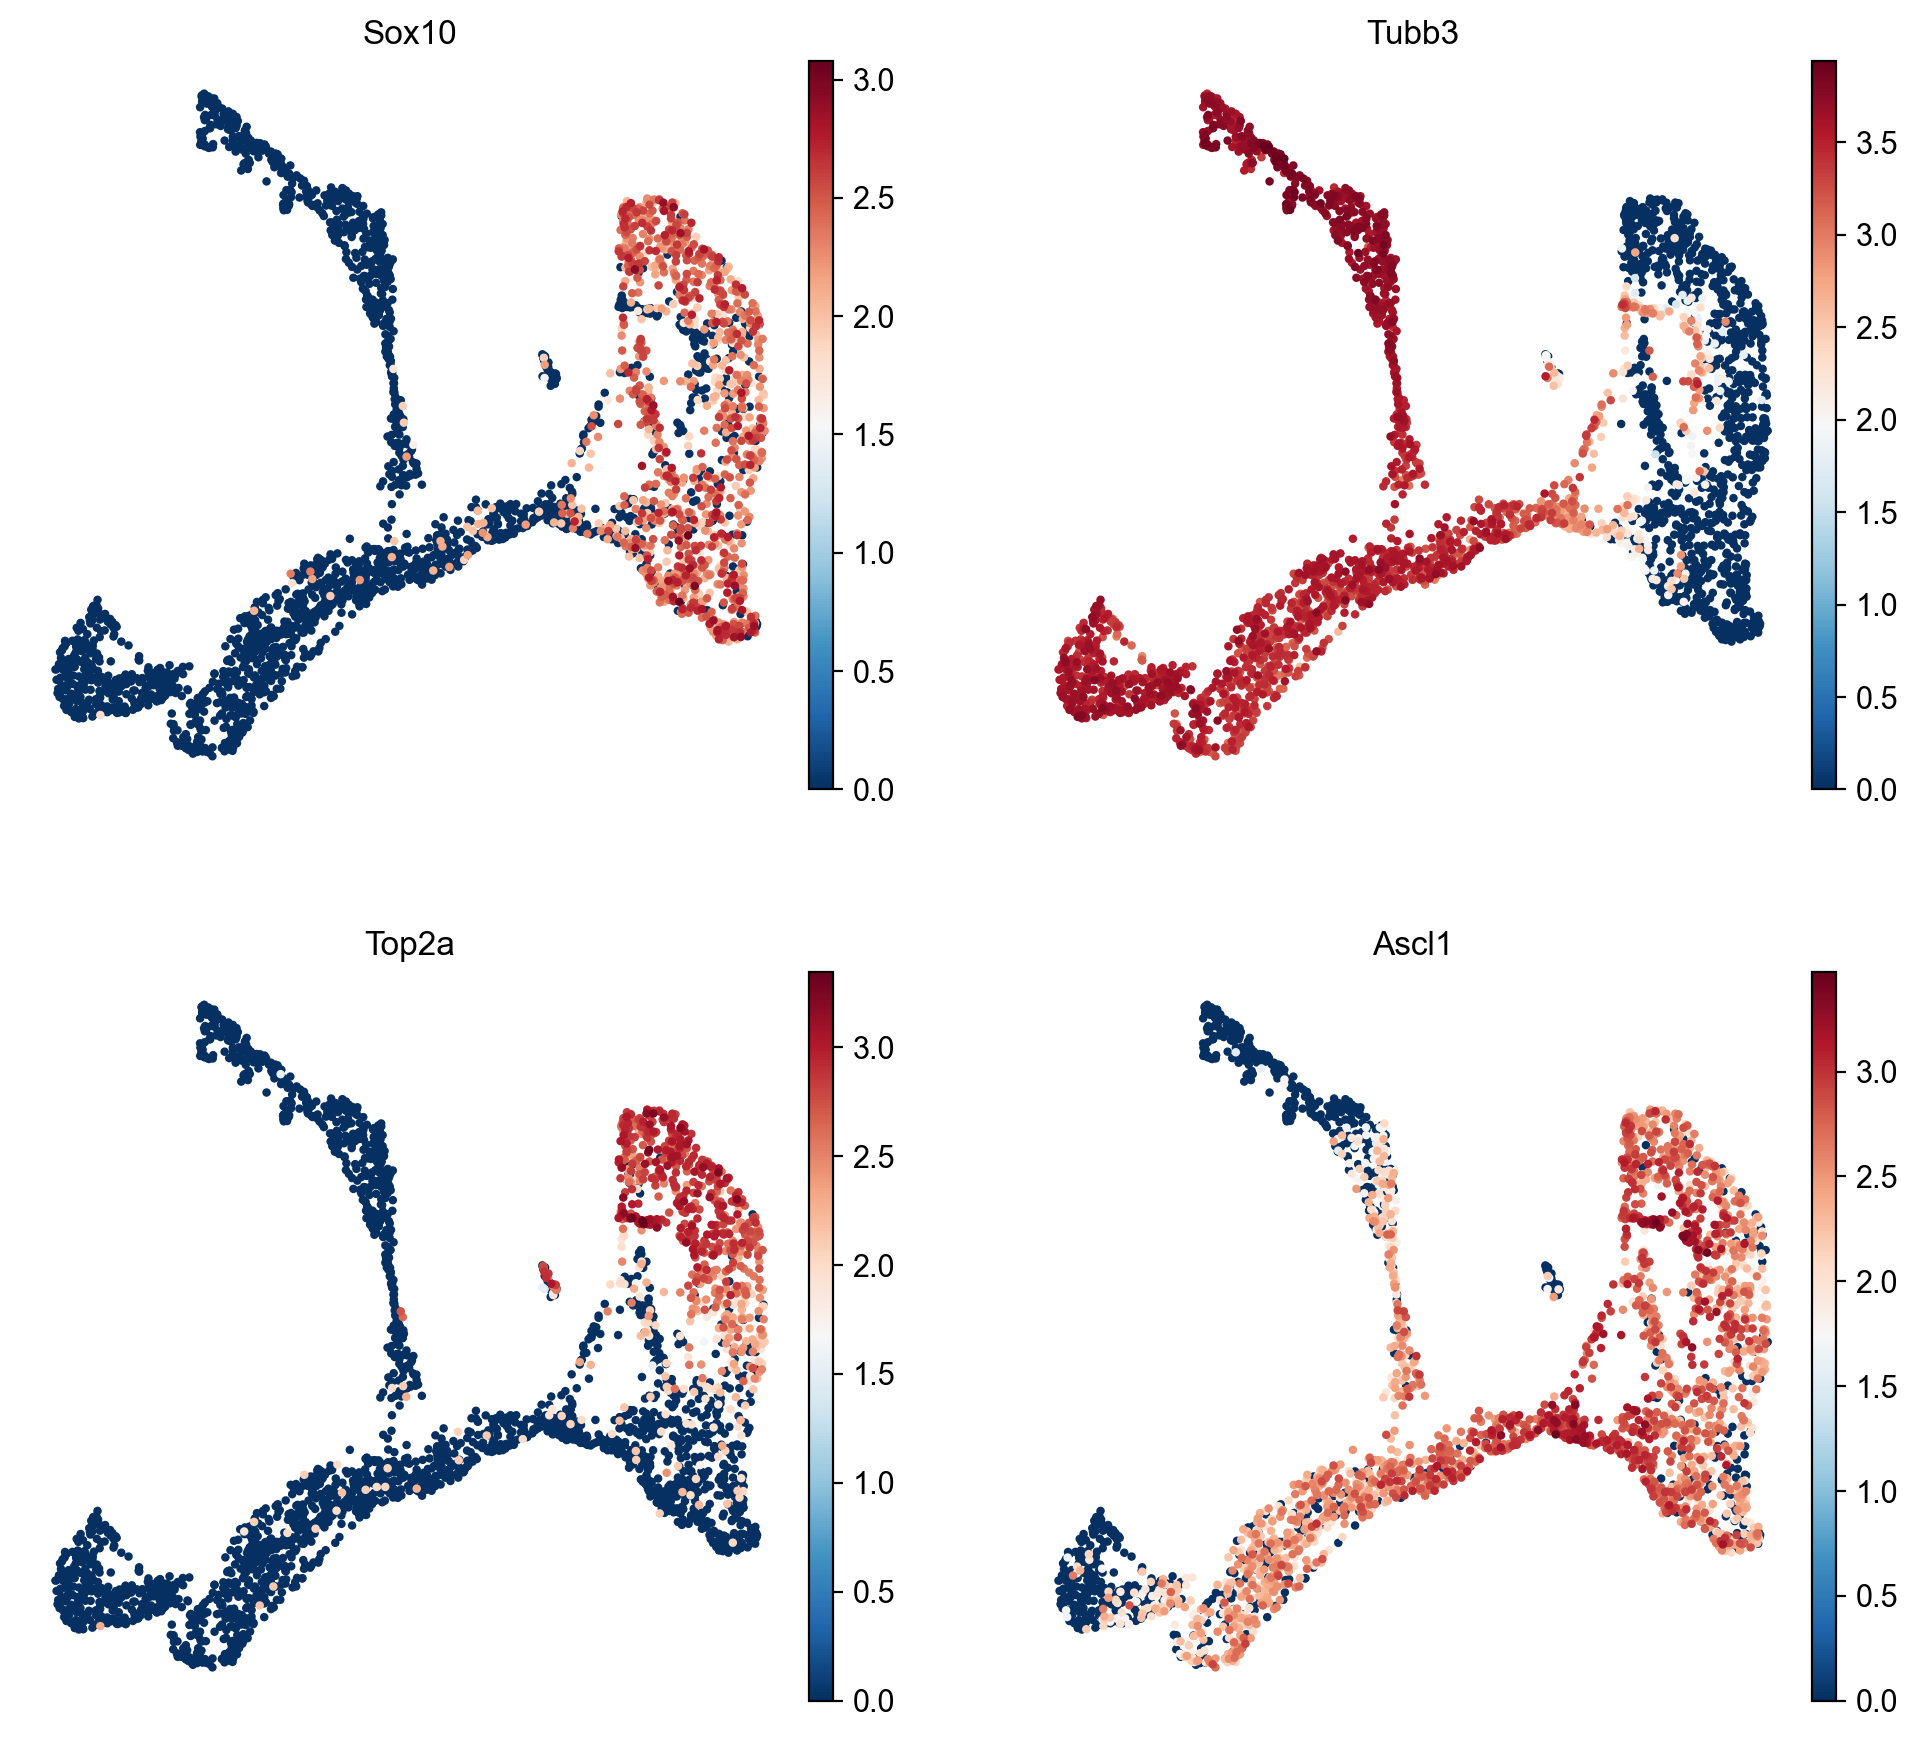

In [3]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata,base=10)
sc.pl.umap(adata,color=["Sox10","Tubb3","Top2a","Ascl1"],ncols=2,frameon=False)

Let's plot the velocity embedding. RNA velocity is not taken in account for the tree building, it only helps to get an idea of the directionality of the data and to manually select a root.

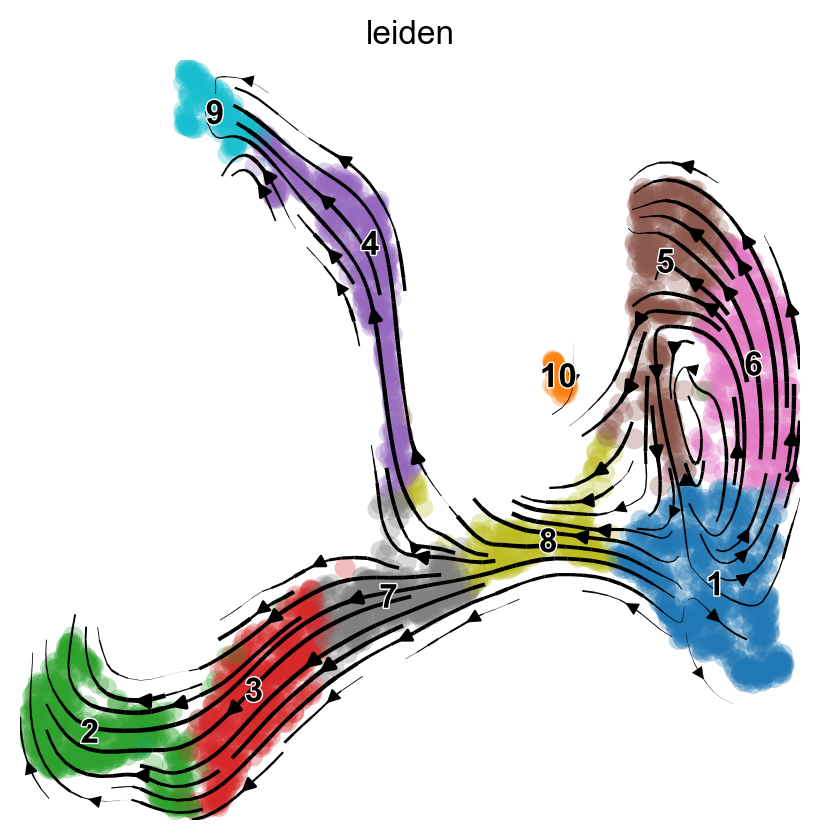

In [4]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color="leiden")

Overall we see a clear transition from cycling Sox10+ SCP to two Tubb3+ neuronal subtypes, with Ascl1 representing the bridge before the bifurcation.

## Fit tree and extract significant features

### Fitting tree using SimplePPT

We will infer a principal tree on PCA space using SimplePPT method.

In [5]:
scf.tl.tree(adata,Nodes=300,use_rep="pca",method="ppt",device="cpu",ppt_sigma=1,ppt_lambda=10000,seed=1)

inferring a principal tree inferring a principal tree --> parameters used 
    300 principal points, sigma = 1, lambda = 10000, metric = euclidean
    fitting:  66%|██████▌   | 33/50 [00:03<00:01,  9.19it/s]
    converged
    finished (0:00:03) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


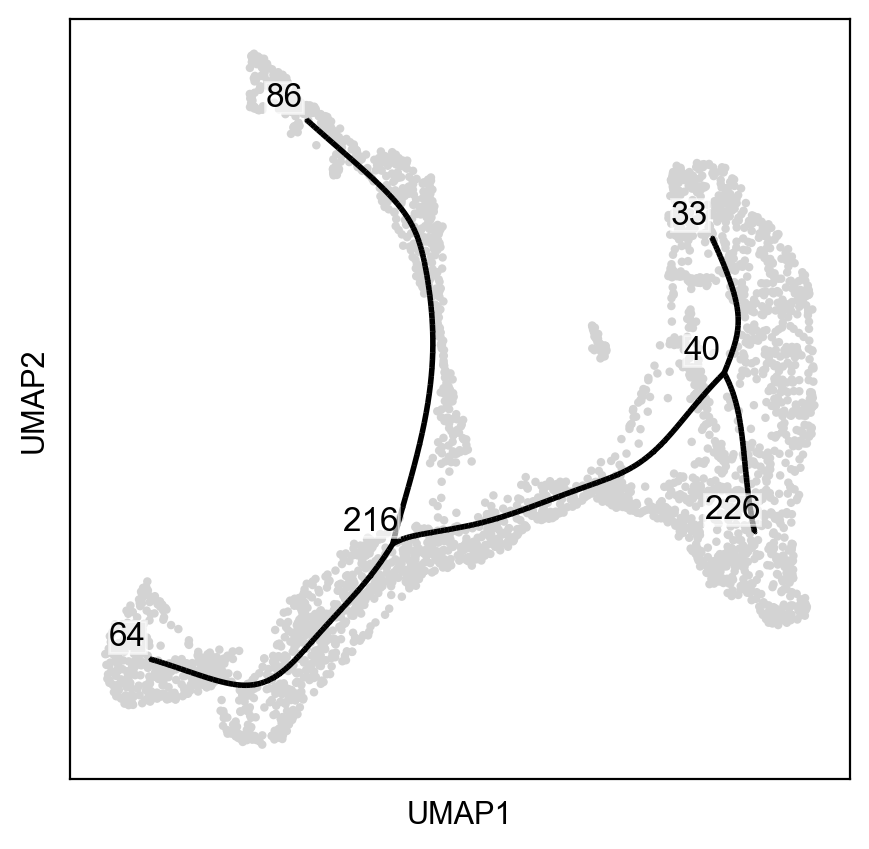

In [6]:
scf.pl.graph(adata,size_nodes=.1)

### Root selection and pseudotime calculation

In [7]:
scf.tl.root(adata,40)

node 40 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [8]:
scf.tl.pseudotime(adata,n_jobs=80,n_map=100,seed=42)

projecting cells onto the principal graph
    mappings: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s]
    finished (0:00:41) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


### Features testing and fitting

In [9]:
scf.tl.test_association(adata,n_jobs=40,A_cut=1)

test features for association with the trajectory
    single mapping : 100%|██████████| 16934/16934 [02:10<00:00, 130.24it/s]
    found 2184 significant features (0:02:10) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


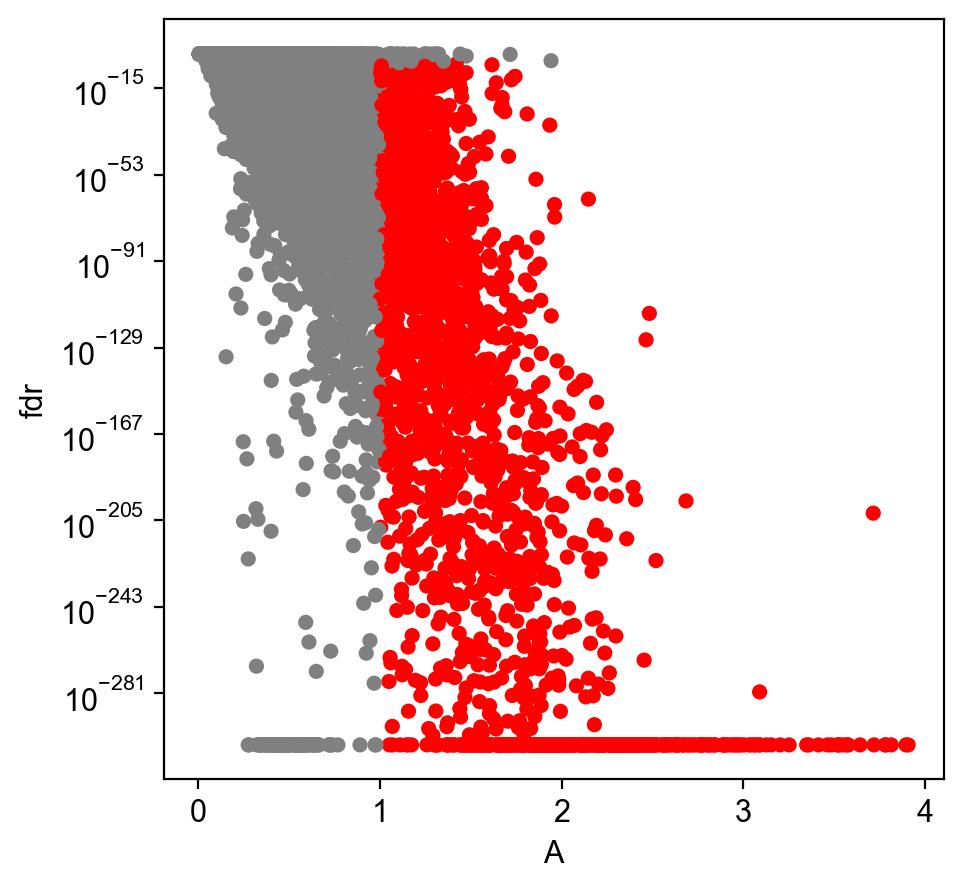

In [10]:
scf.pl.test_association(adata)

In [11]:
scf.tl.fit(adata,n_jobs=40)

fit features associated with the trajectory
    single mapping : 100%|██████████| 2184/2184 [00:29<00:00, 73.03it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:32) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


### Plotting milestones



<div class="alert alert-info">

**Note**    

Milestones are not a result of a clustering, these labels mark cells to their closest tip or fork on the tree. This labelling will help for selecting branches for performing bifurcation analysis.

</div>  

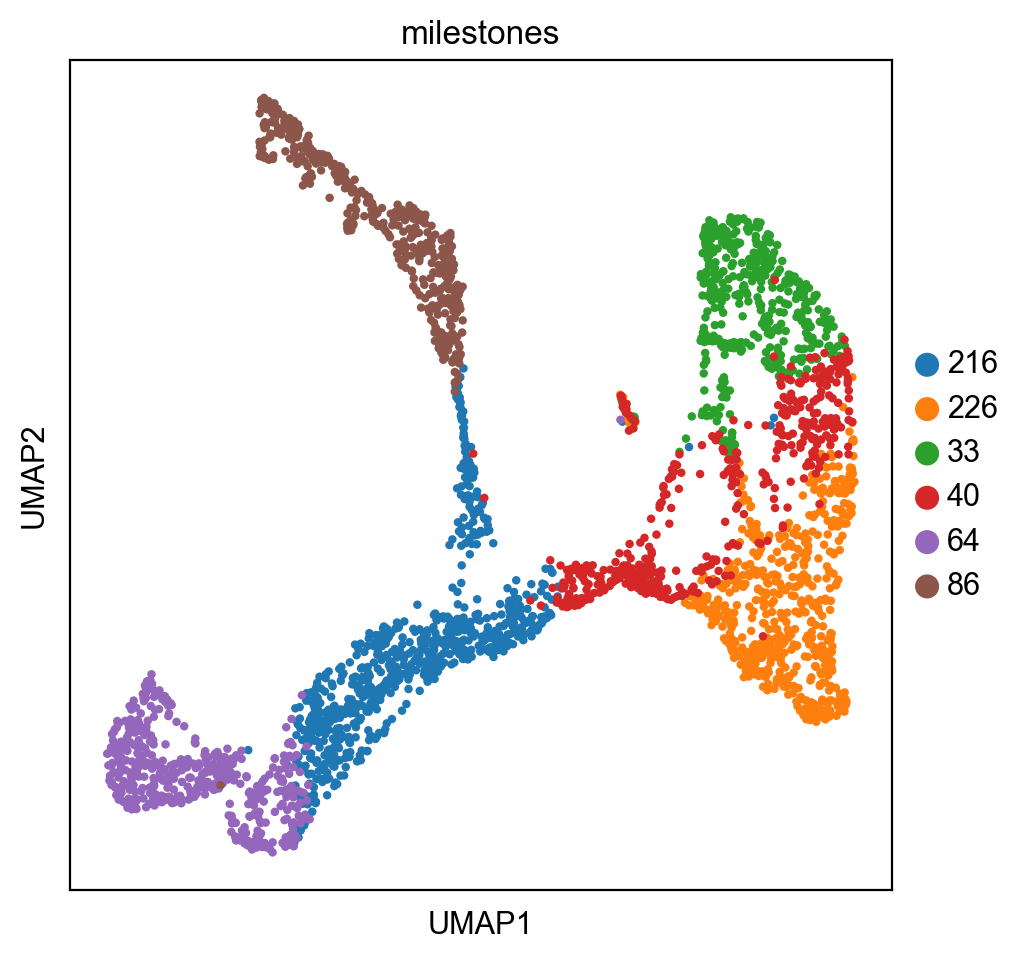

In [12]:
sc.pl.scatter(adata,basis="umap",color="milestones")

Let's rename the milestones according to biological knowledge, the order of the renamed milestones should follow the order of the legend or the one shown with:
**.obs.milestones.cat.categories**

In [13]:
mil=["bifurcation","glia","cycling","root","EN1","EN2"]
scf.tl.rename_milestones(adata,mil)

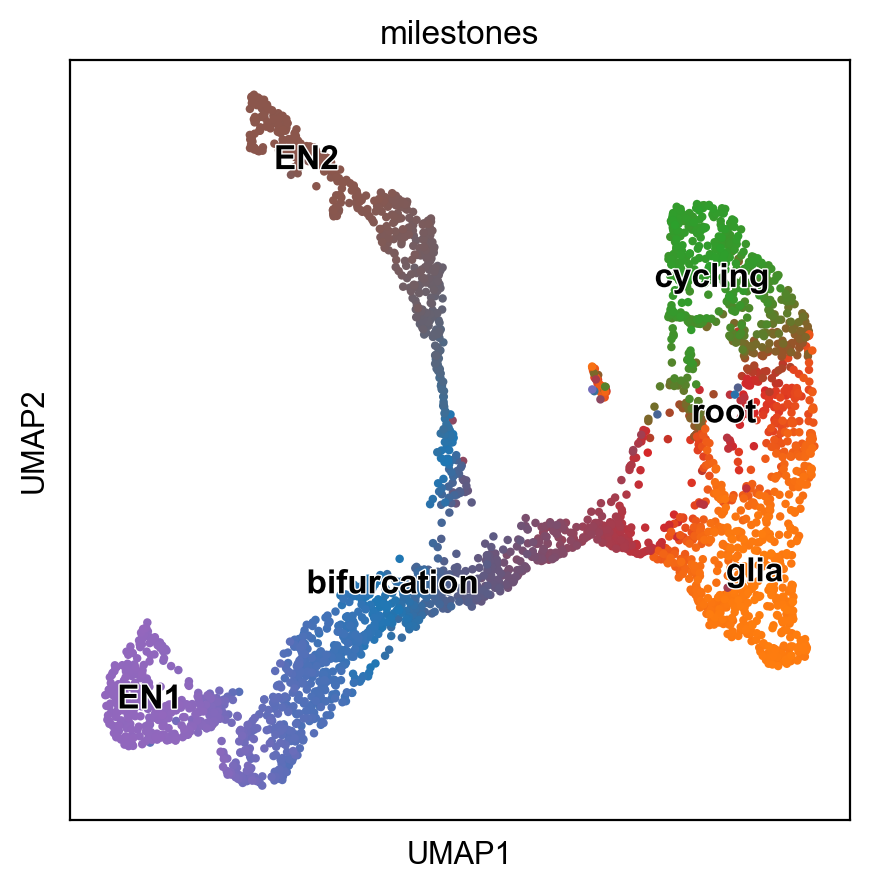

In [14]:
scf.pl.milestones(adata,annotate=True)

## Bifurcation analysis

We now focus on the bifurcation between the two neuronal types:

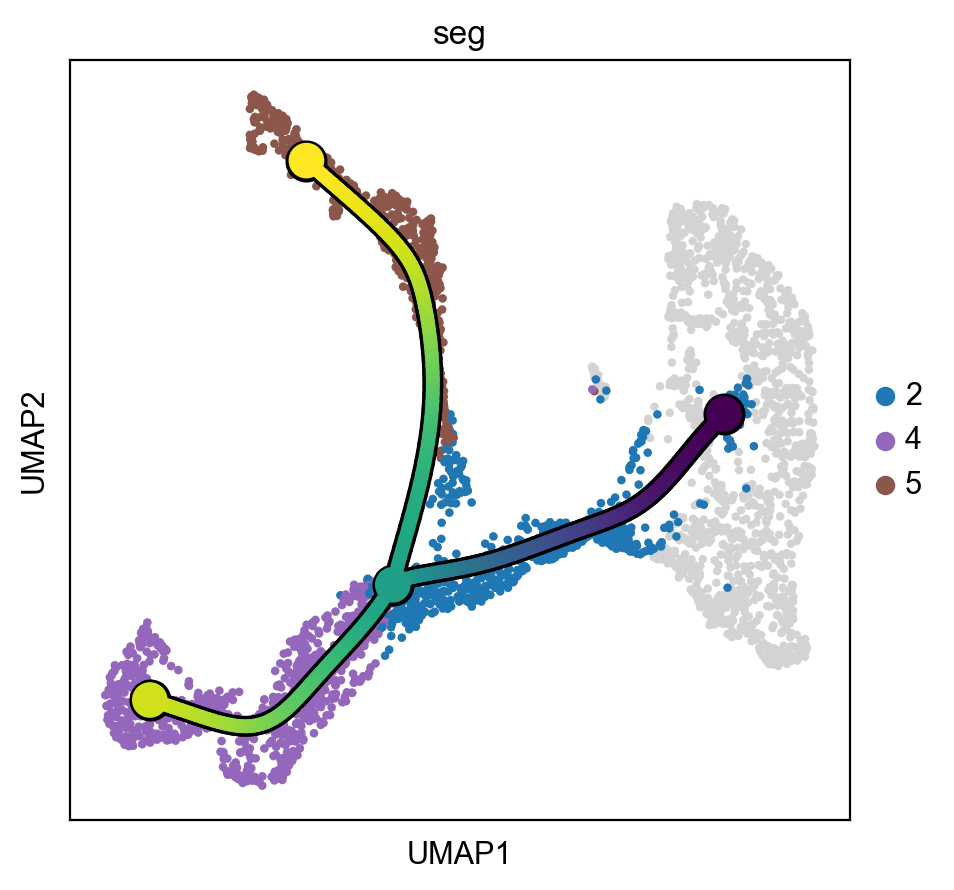

In [16]:
scf.pl.trajectory(adata,root_milestone="root",milestones=["EN1","EN2"],color_cells="seg")

### Testing all features for branch-specificity and upregulation from progenitor branch 

Let's do differential gene expression between two branches, we also need to determine which genes are differentially upregulated after bifurcation point.

In [17]:
scf.tl.test_fork(adata,root_milestone="root",milestones=["EN1","EN2"],n_jobs=40,rescale=True)

testing fork
    single mapping
    Differential expression: 100%|██████████| 2184/2184 [00:14<00:00, 151.56it/s]
    test for upregulation for each leave vs root
    upreg EN2: 100%|██████████| 1736/1736 [00:01<00:00, 1049.04it/s]
    finished (0:00:17) --> added 
    .uns['root->EN1<>EN2']['fork'], DataFrame with fork test results.


We estimate branch-specifc features by applying a threshold on the difference of amplitude compared to the other branch.

In [18]:
scf.tl.branch_specific(adata,root_milestone="root",milestones=["EN1","EN2"],effect=0.5)

    branch specific features: EN2: 203, EN1: 44
    finished --> updated 
    .uns['root->EN1<>EN2']['fork'], DataFrame updated with additionnal 'branch' column.


In [19]:
scf.tl.activation_lm(adata,root_milestone="root",milestones=["EN1","EN2"],pseudotime_offset=3,n_jobs=20)

    single mapping
    prefork activation: 100%|██████████| 247/247 [00:20<00:00, 11.97it/s]
    28 early and 16 late features specific to leave EN1
    27 early and 176 late features specific to leave EN2
    finished (0:00:22) --> updated 
    .uns['root->EN1<>EN2']['fork'], DataFrame updated with additionnal 'slope','pval','fdr','prefork_signi' and 'module' columns.


In [20]:
scf.tl.slide_cells(adata,root_milestone="root",milestones=["EN1","EN2"],win=100)
scf.tl.slide_cors(adata,root_milestone="root",milestones=["EN1","EN2"])

--> added 
    .uns['root->EN1<>EN2']['cell_freq'], probability assignment of cells on 24 non intersecting windows.
--> added 
    .uns['root->EN1<>EN2']['corAB'], gene-gene correlation modules.


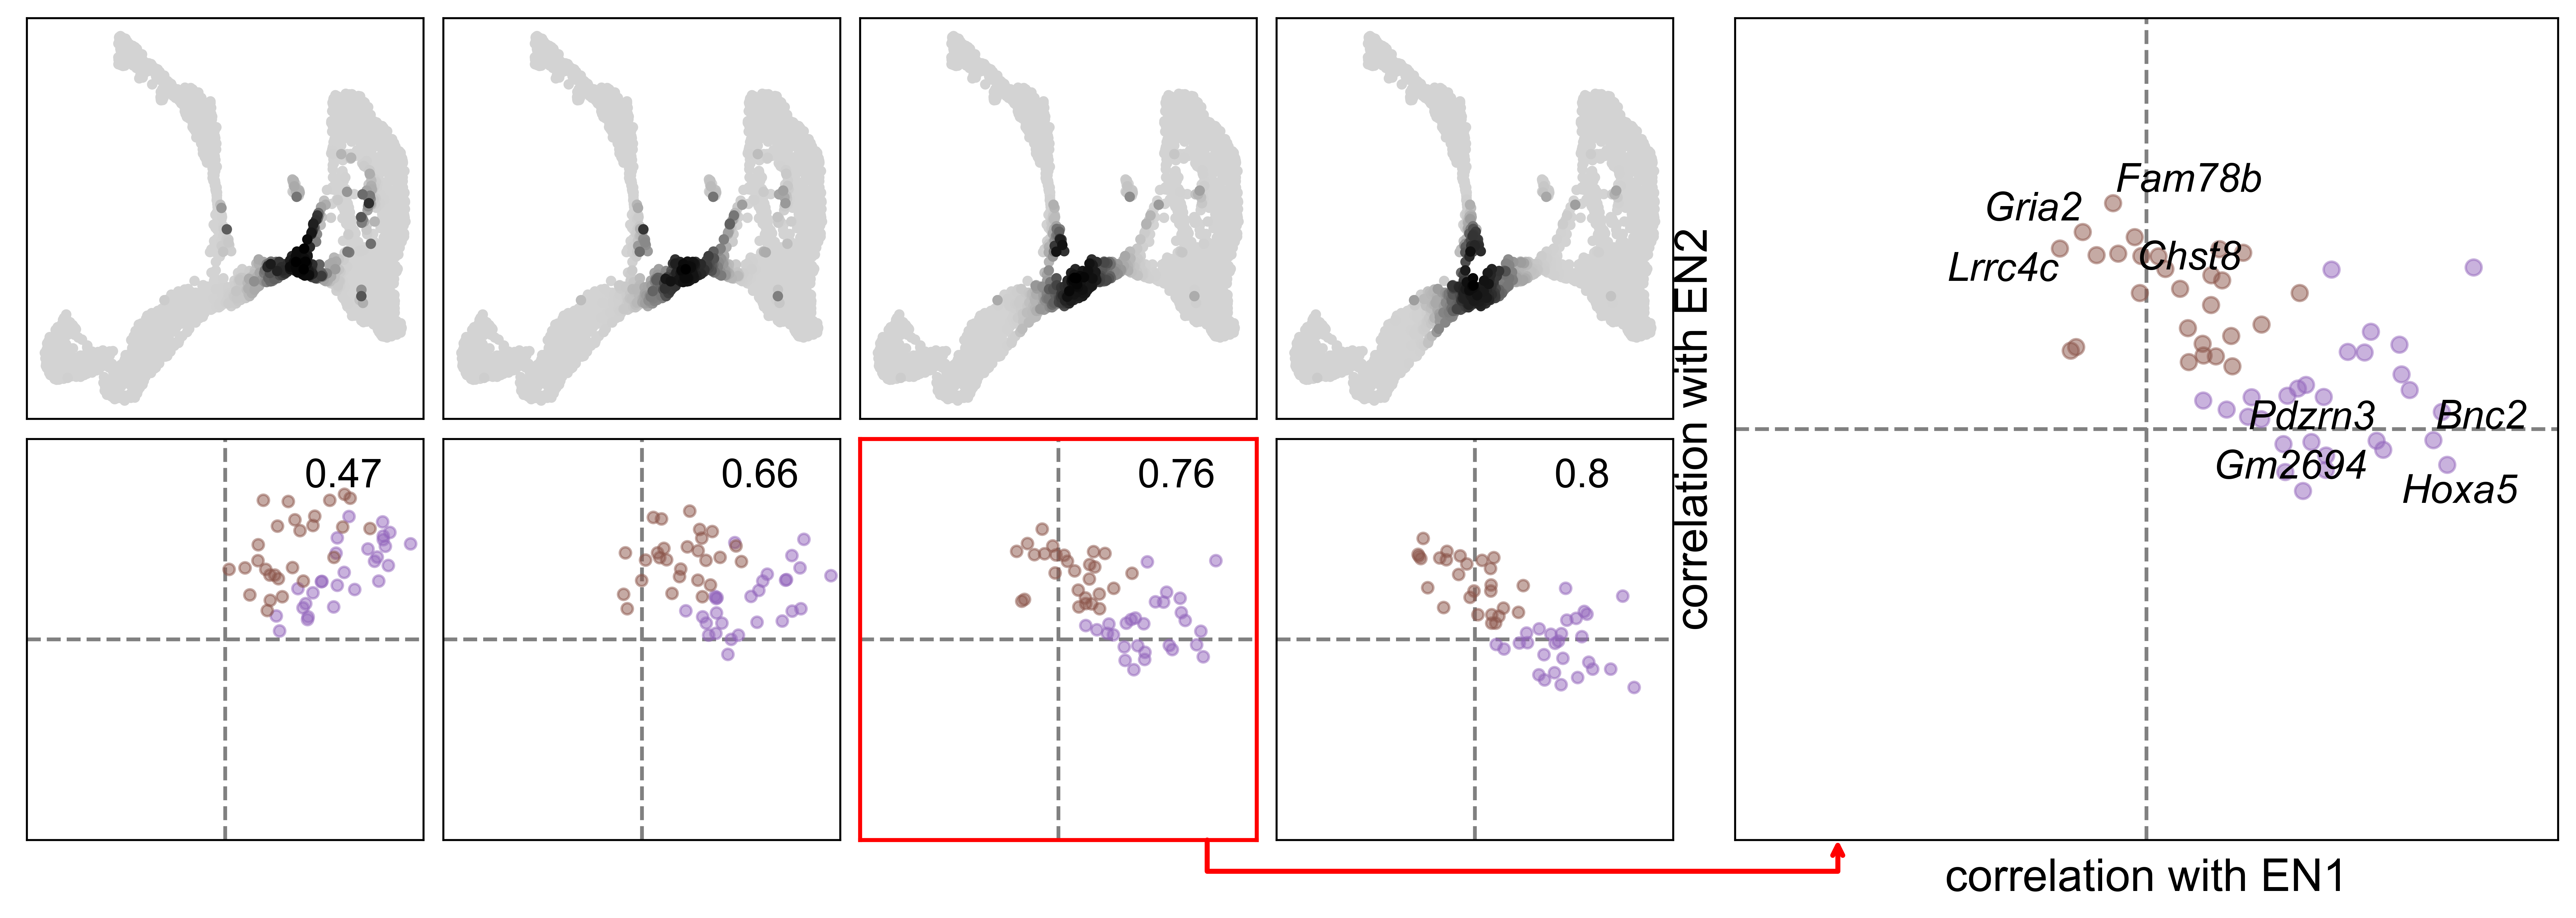

In [21]:
import scvelo as scv
scv.set_figure_params('scvelo',figsize=(5,5),dpi=300)
scf.pl.slide_cors(adata,root_milestone="root",milestones=["EN1","EN2"],
                  win_keep=[1,2,3,4],focus=2,kwargs_text=dict(fontsize=16,style="italic"),save="EN1_EN2.pdf")


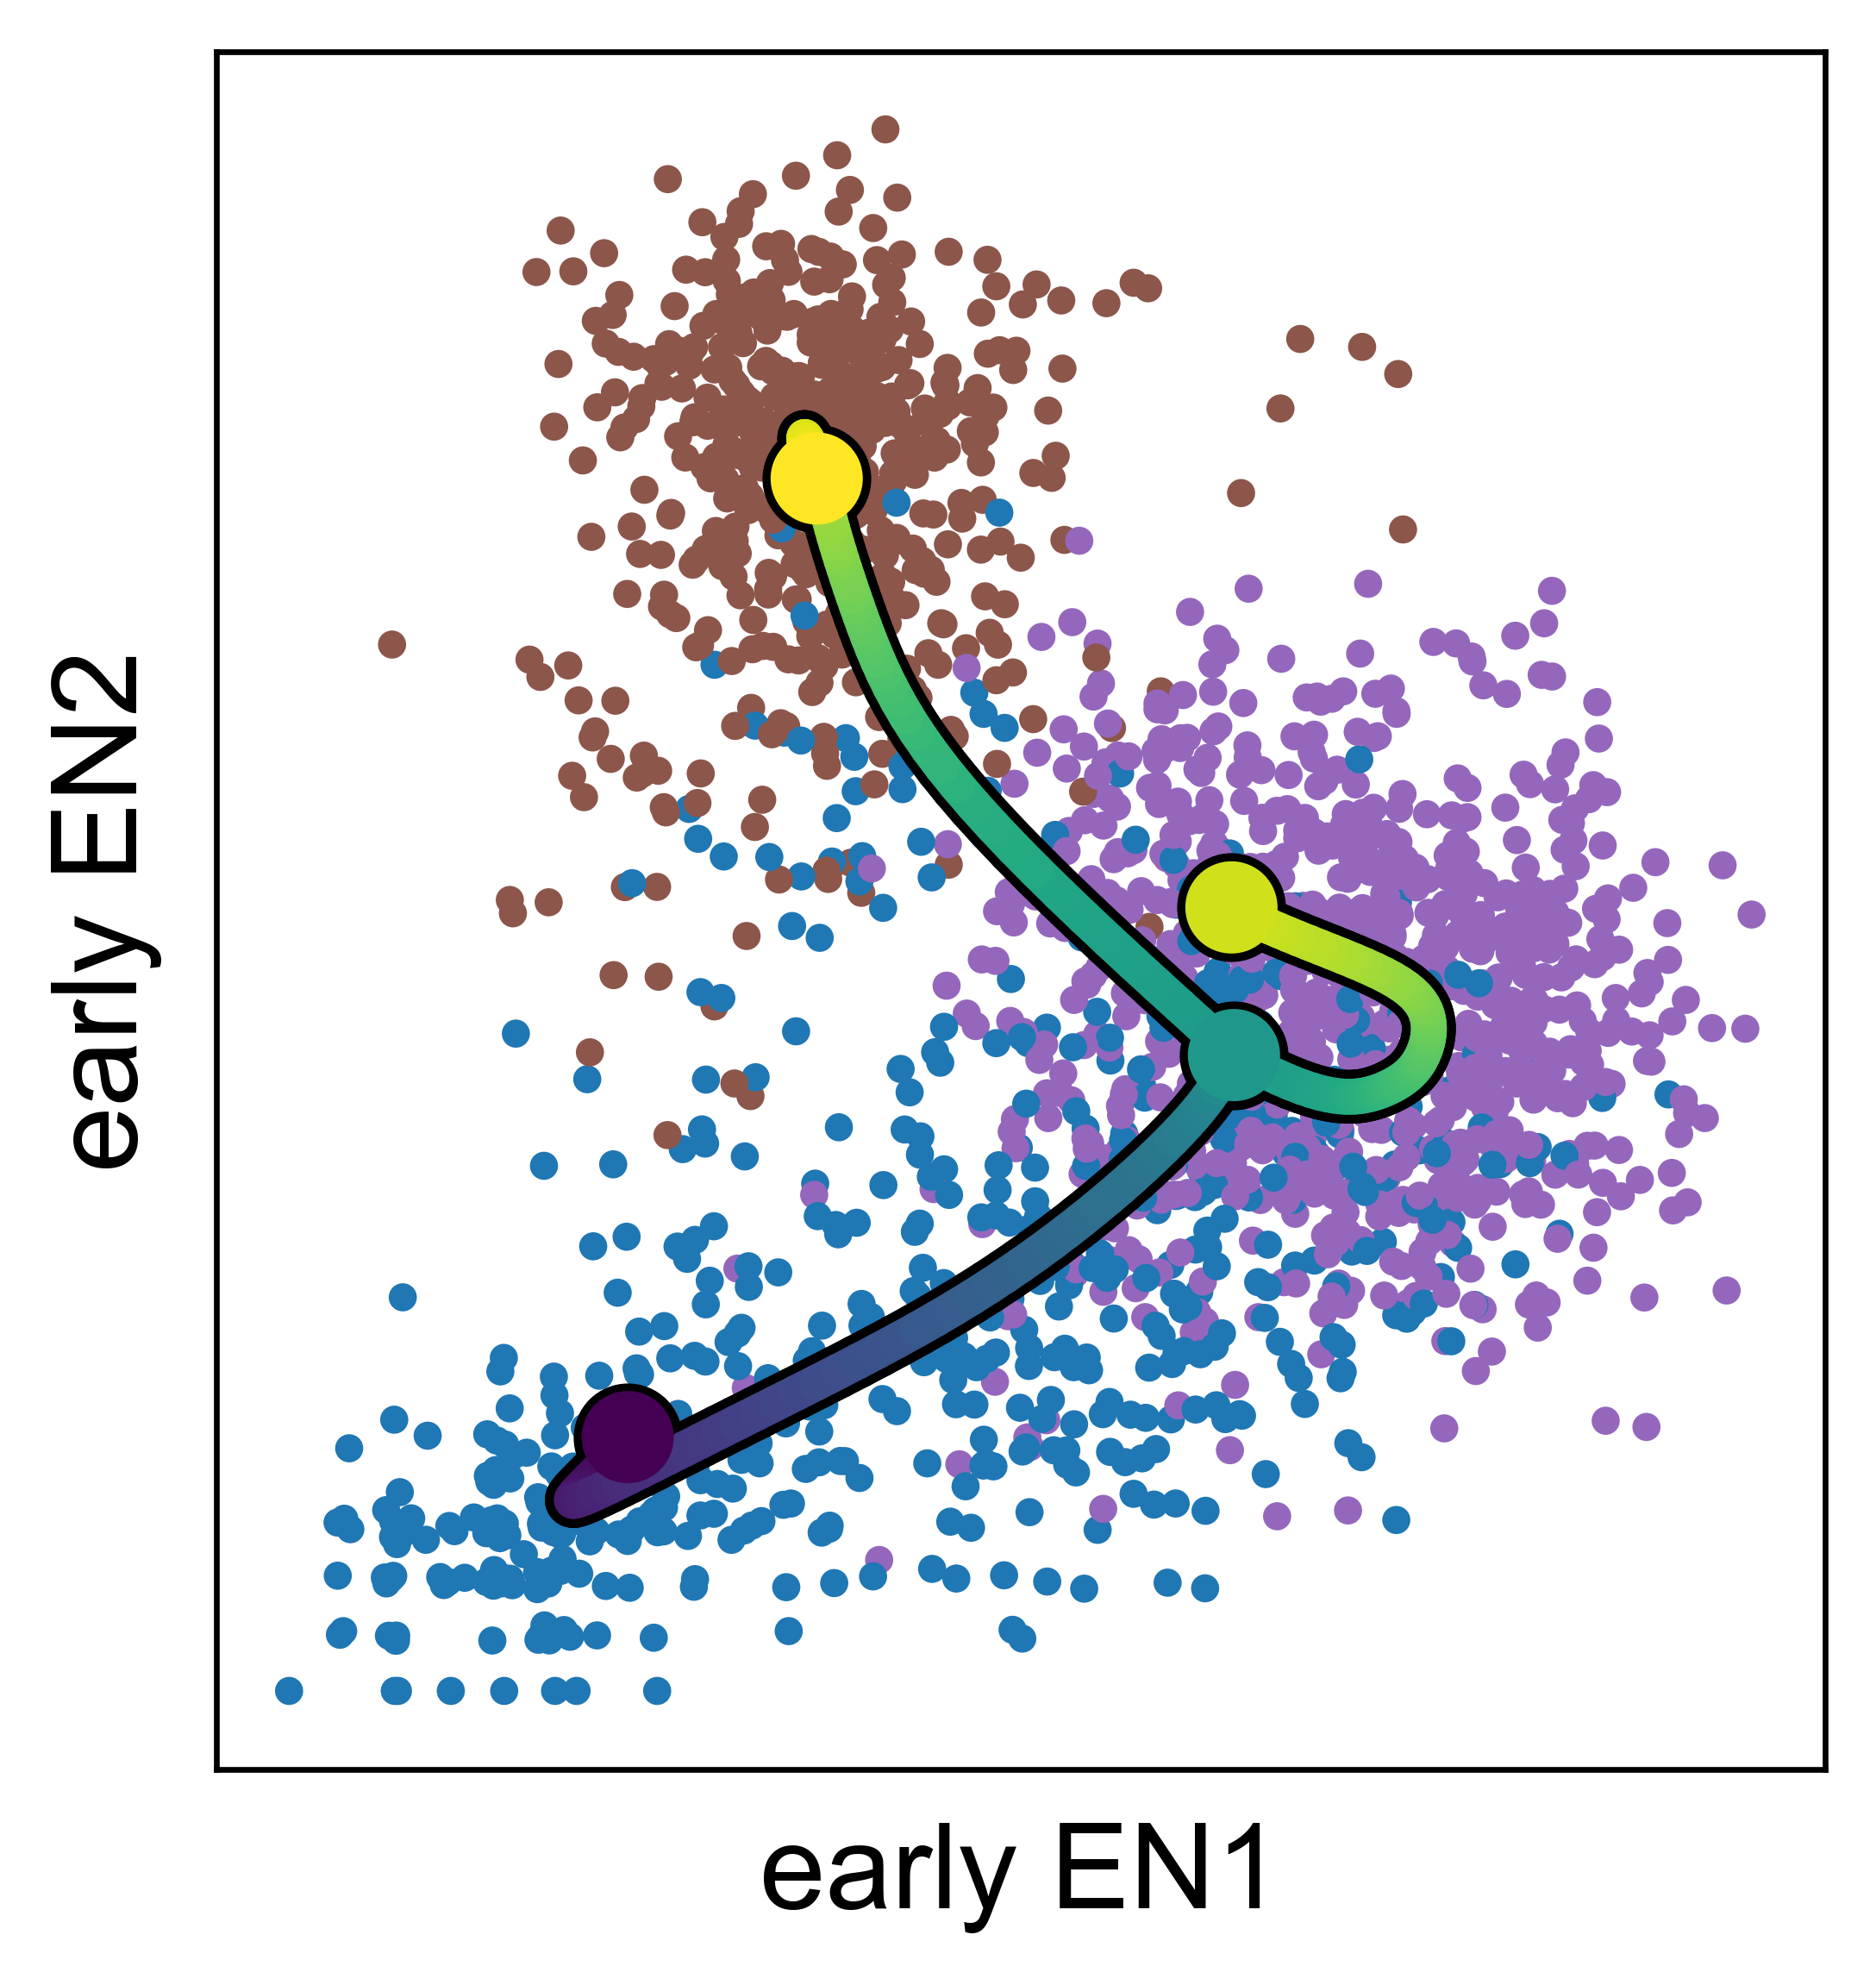

In [22]:
import scvelo as scv
scv.set_figure_params(figsize=(4,4),fontsize=18,dpi=300)
scf.pl.modules(adata,root_milestone="root",milestones=["EN1","EN2"],color="seg",module="early",show_traj=True,
              save="upreg_early.pdf")

In [23]:
adata_s=scf.tl.subset_tree(adata,root_milestone="root",milestones=["EN1","EN2"],copy=True)

subsetting tree
node 24 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    finished (0:00:02) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.
    finished (0:00:00) --> tree extracted
--> added 
    .obs['old_milestones'], previous milestones from intial tree


In [30]:
scf.tl.pseudotime(adata_s,n_jobs=80,n_map=100)
adata_s.uns["seg_colors"]=[np.array(adata_s.uns["milestones_colors"])[pd.Series(adata_s.uns["graph"]["milestones"])==t][0] for t in adata_s.uns["graph"]["pp_seg"].to]

projecting cells onto the principal graph
    mappings: 100%|██████████| 100/100 [00:39<00:00,  2.53it/s]
    finished (0:00:41) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


NameError: name 'np' is not defined

In [31]:
scf.tl.fit(adata_s,features=scf.get.fork_stats(adata,root_milestone="root",milestones=["EN1","EN2"]).index,n_jobs=80)

fit features associated with the trajectory
    single mapping : 100%|██████████| 247/247 [00:02<00:00, 99.83it/s] 
    finished (adata subsetted to keep only fitted features!) (0:00:02) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


In [32]:
from scvelo.preprocessing.neighbors import get_connectivities
sc.pp.neighbors(adata_s,n_neighbors=30,n_pcs=10)
adata_s.layers["knn_smoothed"]=get_connectivities(adata_s).dot(adata_s.X)

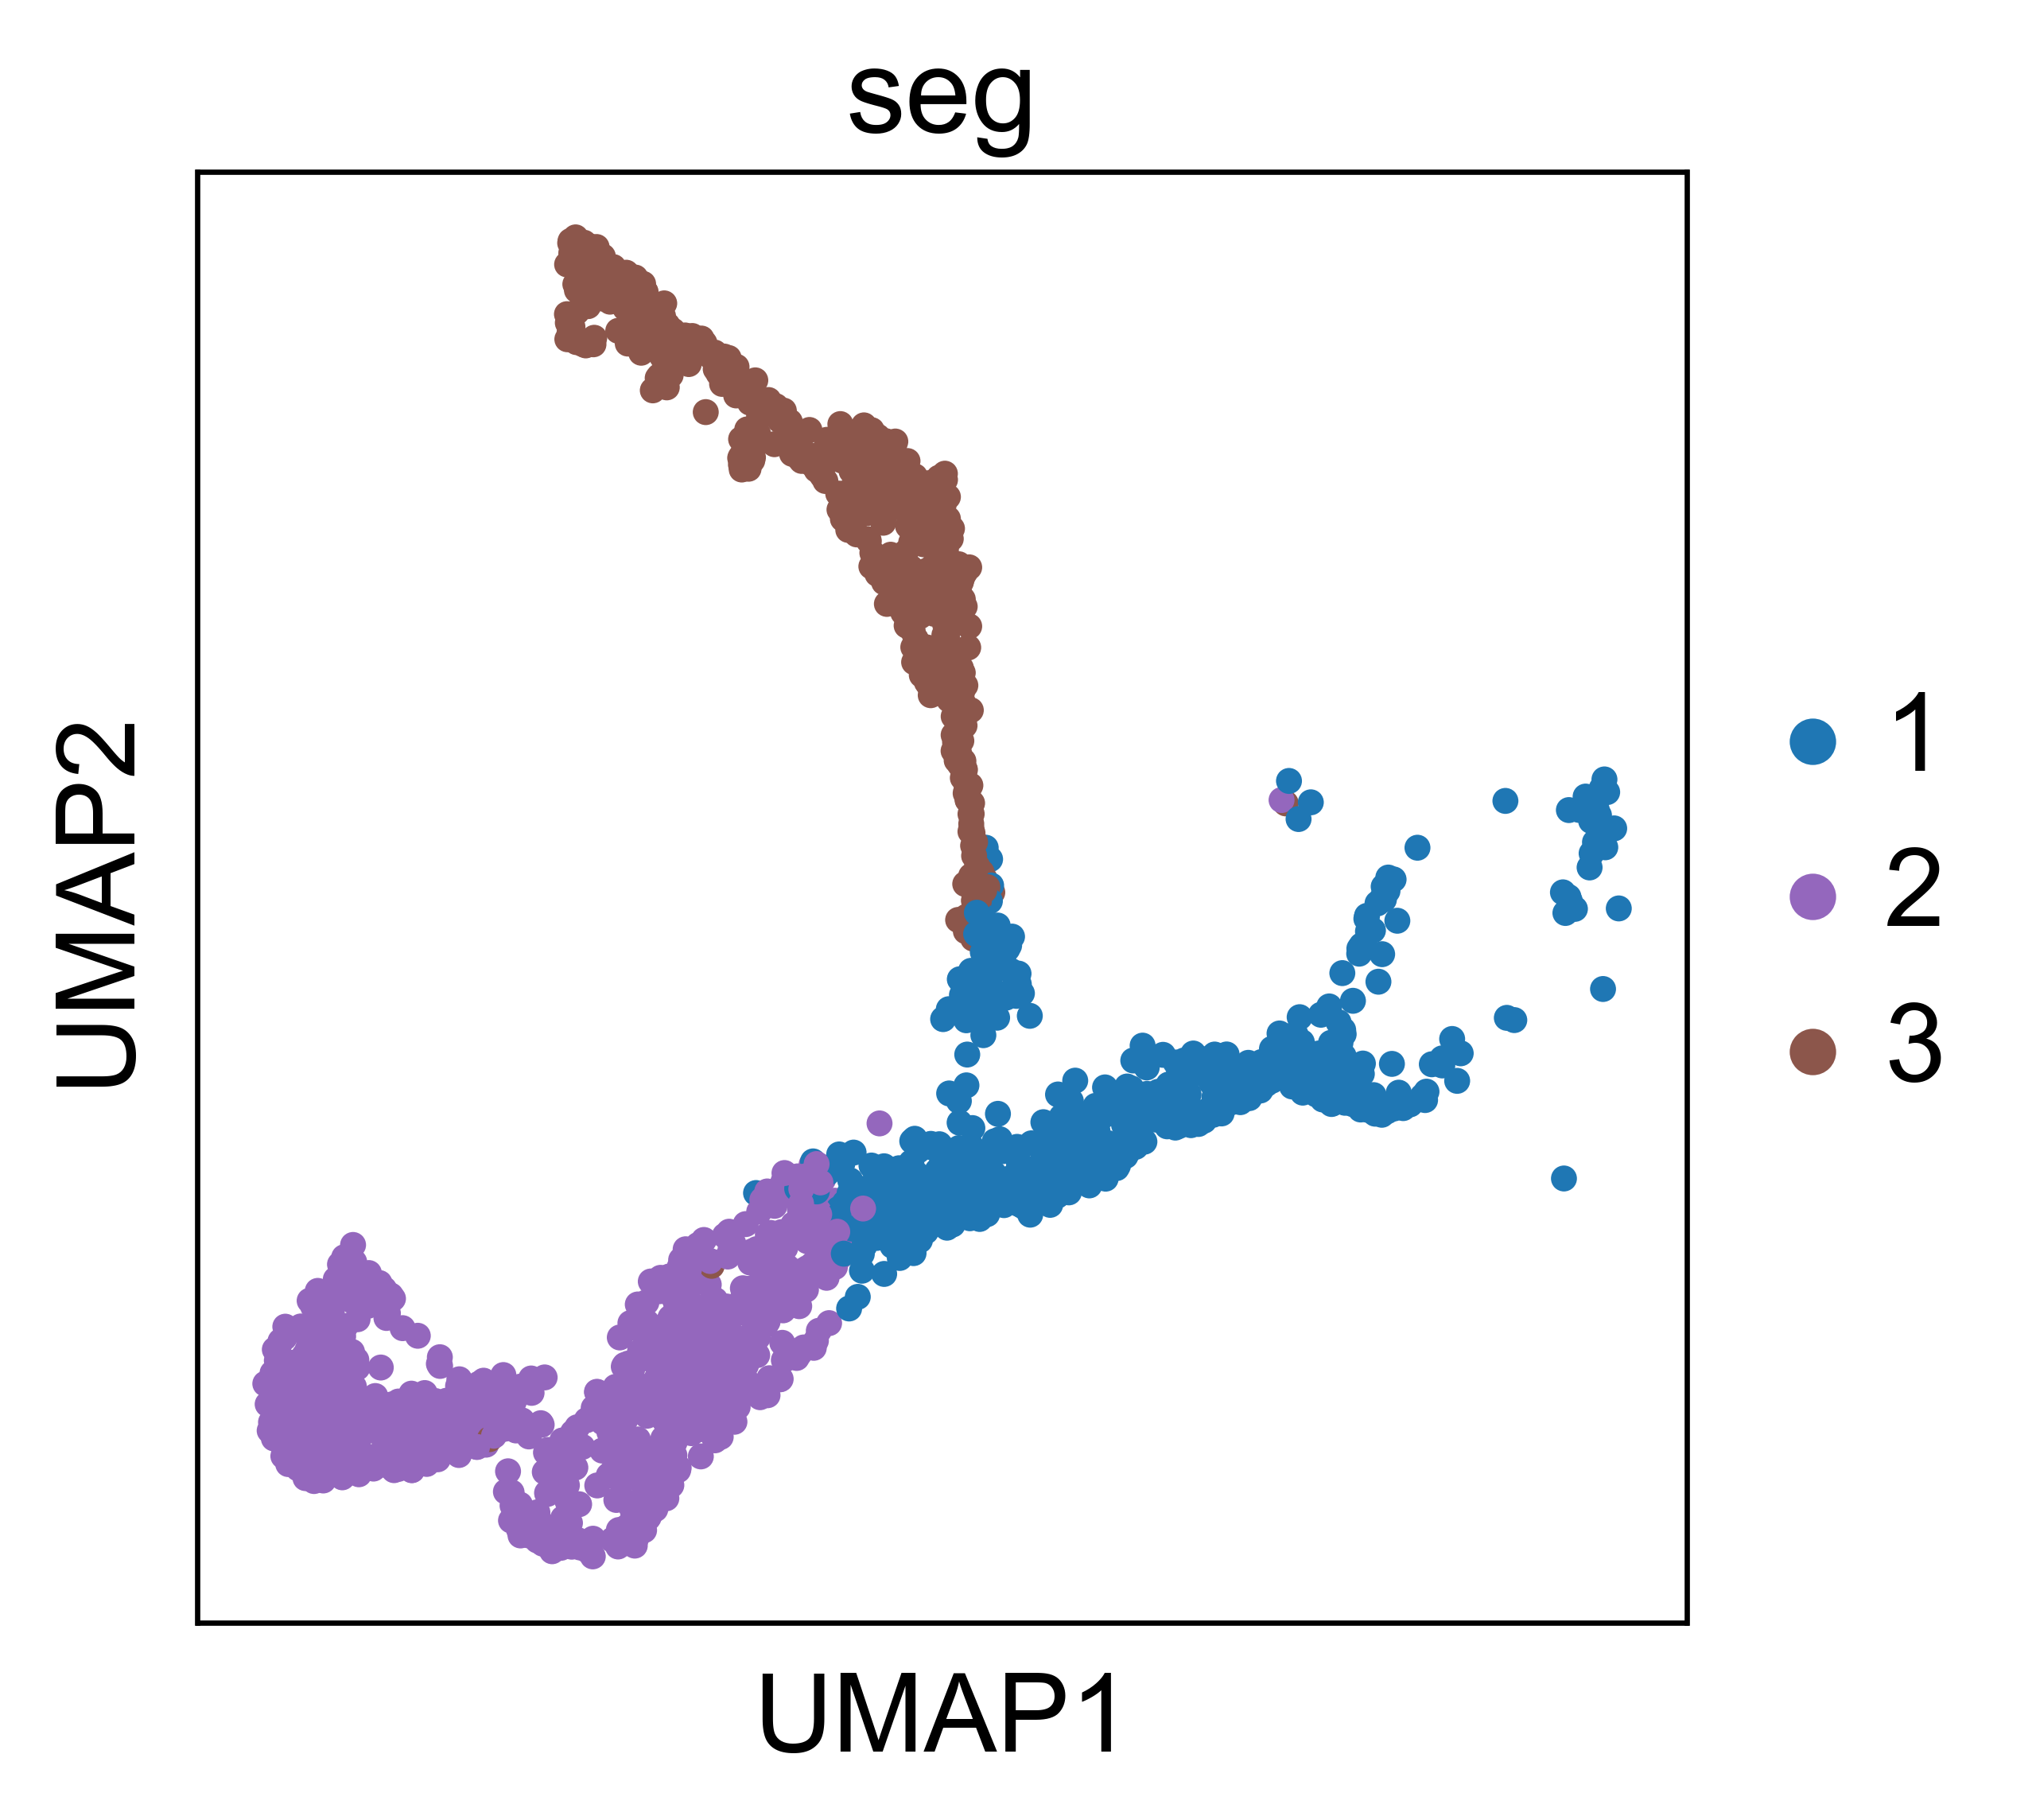

In [34]:
sc.pl.umap(adata_s,color="seg")

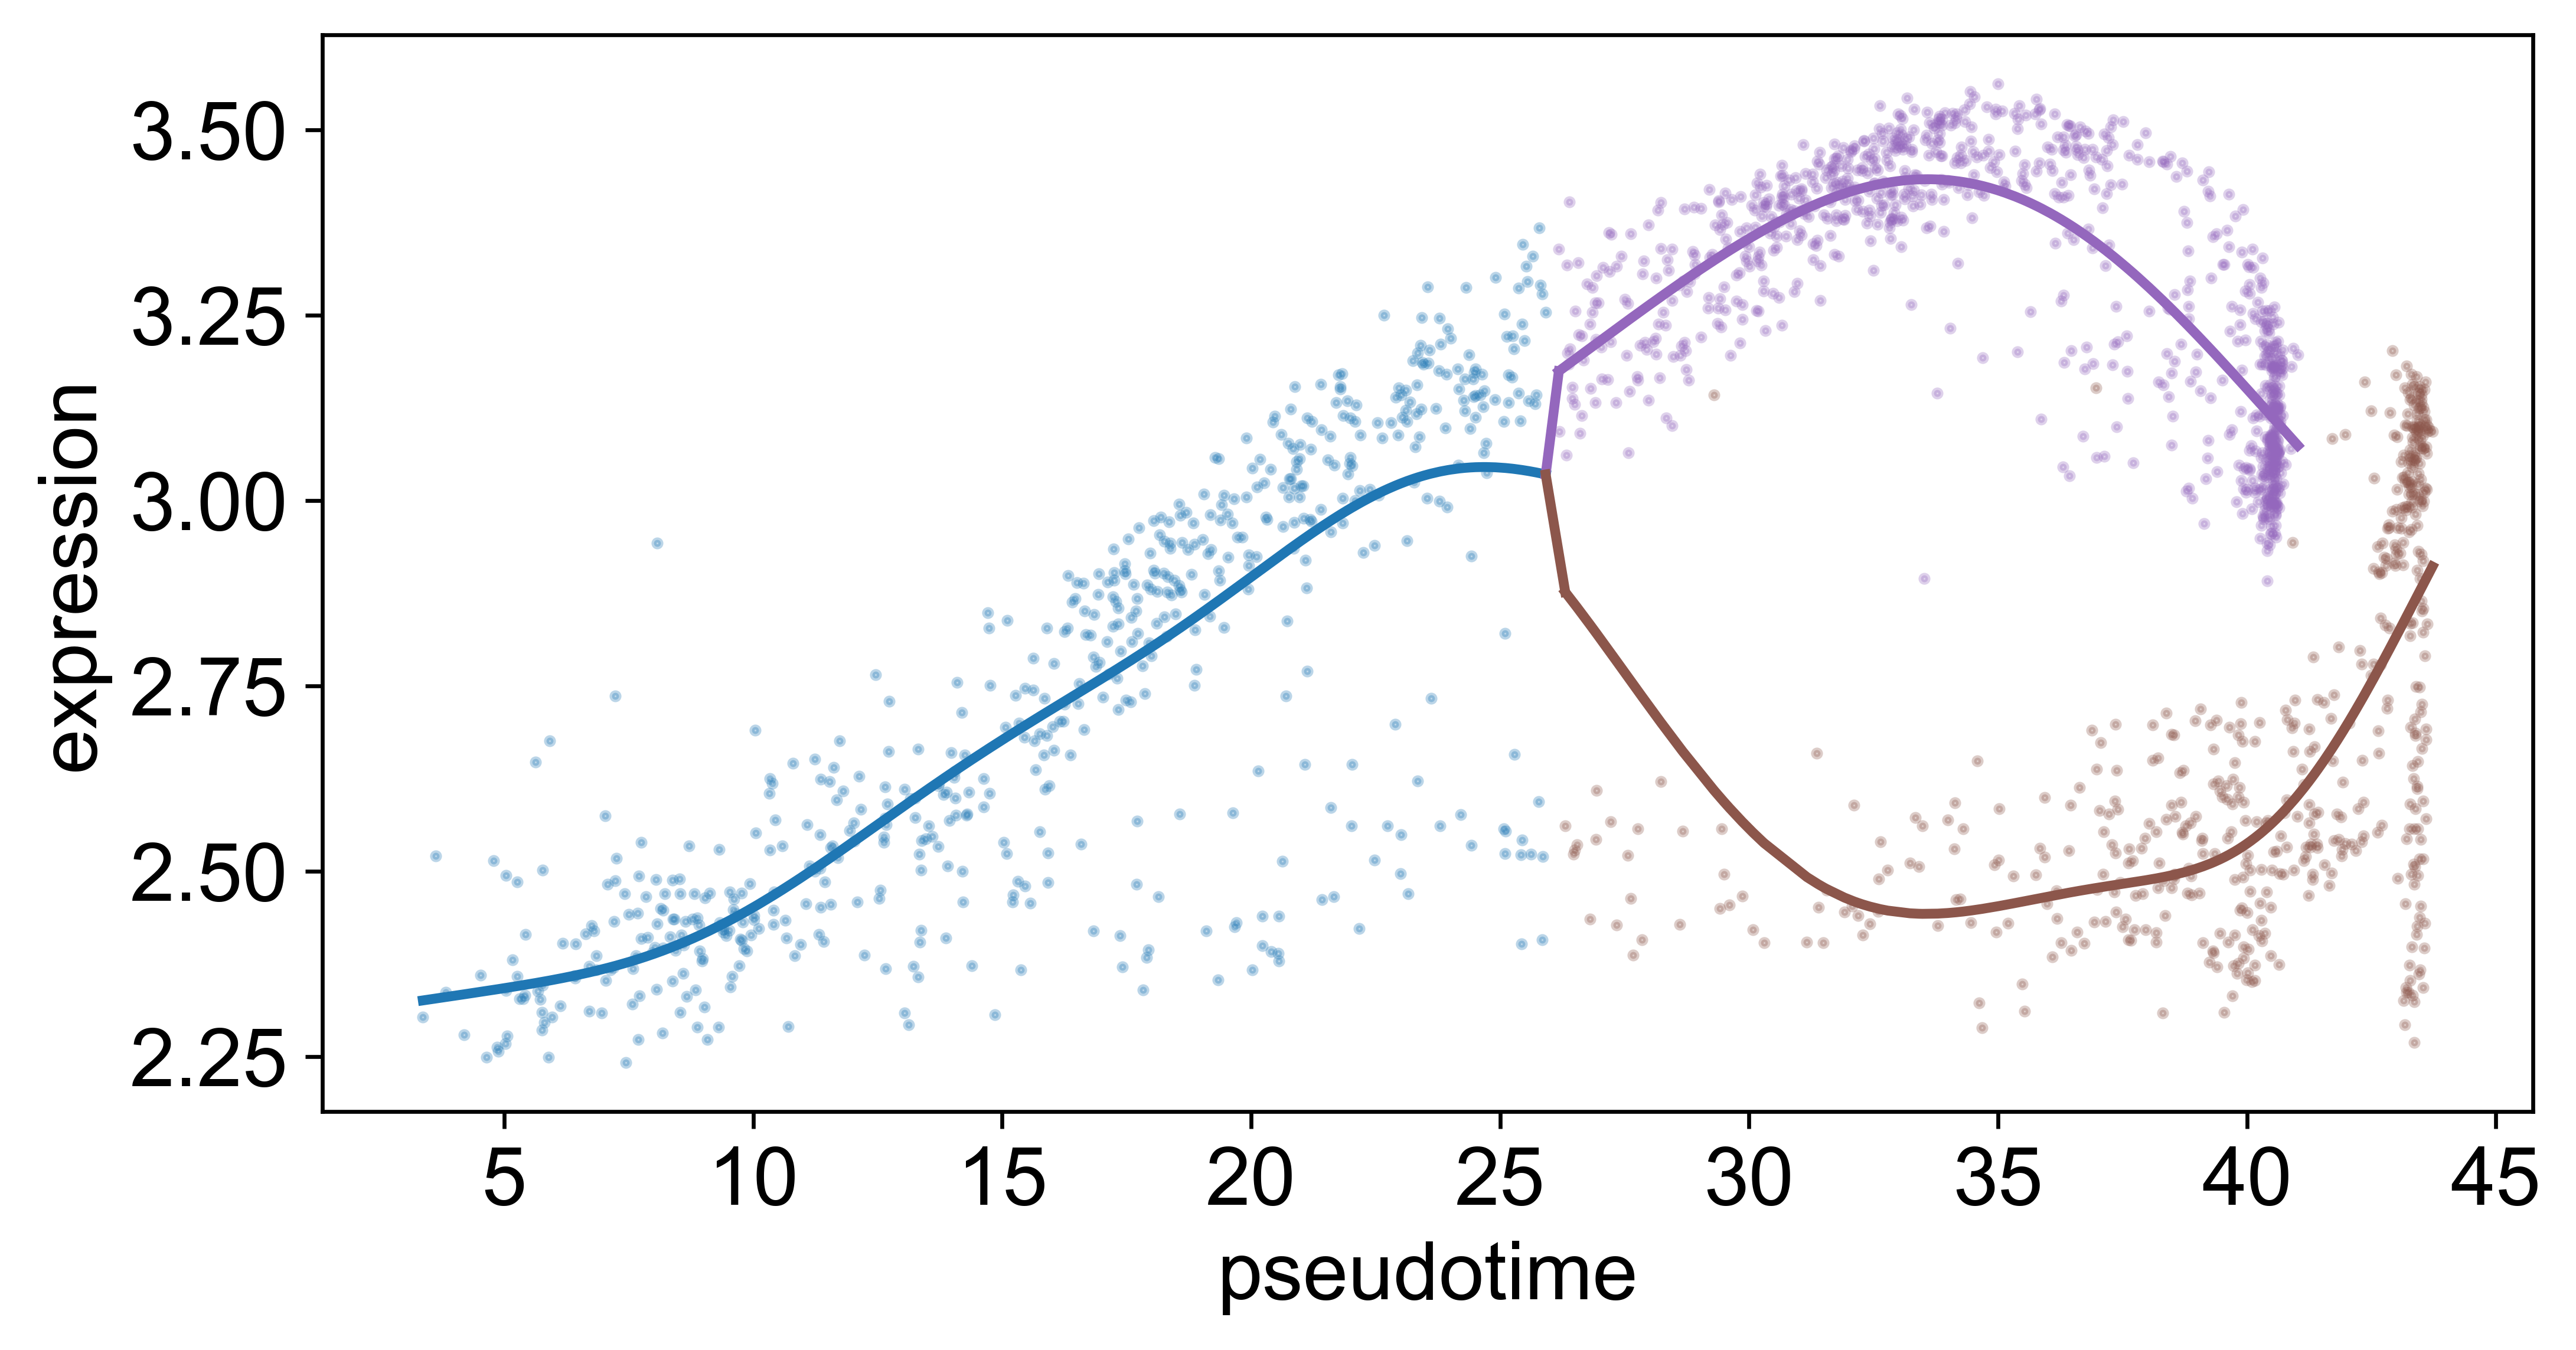

In [35]:
scf.pl.single_trend(adata_s,"Hoxa5",root_milestone="root",layer="knn_smoothed",milestones=["EN1","EN2"],plot_emb=False)

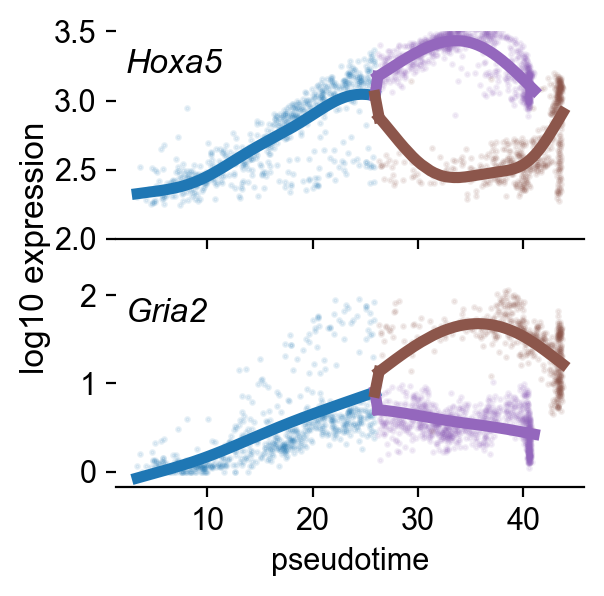

In [46]:
scv.set_figure_params(figsize=(4,4))
import matplotlib.pyplot as plt
fig,axs=plt.subplots(2,1,sharex=True,figsize=(3,3))
scf.pl.single_trend(adata_s,"Hoxa5",layer="knn_smoothed",root_milestone="root",milestones=["EN1","EN2"],
                    alpha_expr=.1,plot_emb=False,fitted_linewidth=4,show=False,ax_trend=axs[0])
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['left'].set_visible(False)
axs[0].set_xlabel("")
axs[0].set_ylabel("")
axs[0].set_ylim([2,3.5])
axs[0].annotate("Hoxa5",(.02,.8),xycoords="axes fraction",style="italic")

scf.pl.single_trend(adata_s,"Gria2",layer="knn_smoothed",root_milestone="root",milestones=["EN1","EN2"],
                    alpha_expr=.1,plot_emb=False,fitted_linewidth=4,show=False,ax_trend=axs[1])

axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].set_ylabel("")

fig.text(0.02,.35,"log10 expression",fontdict=dict(rotation=90))
axs[1].annotate("Gria2",(.02,.8),xycoords="axes fraction",style="italic")

plt.savefig("figures/early_trends.pdf",dpi=300)

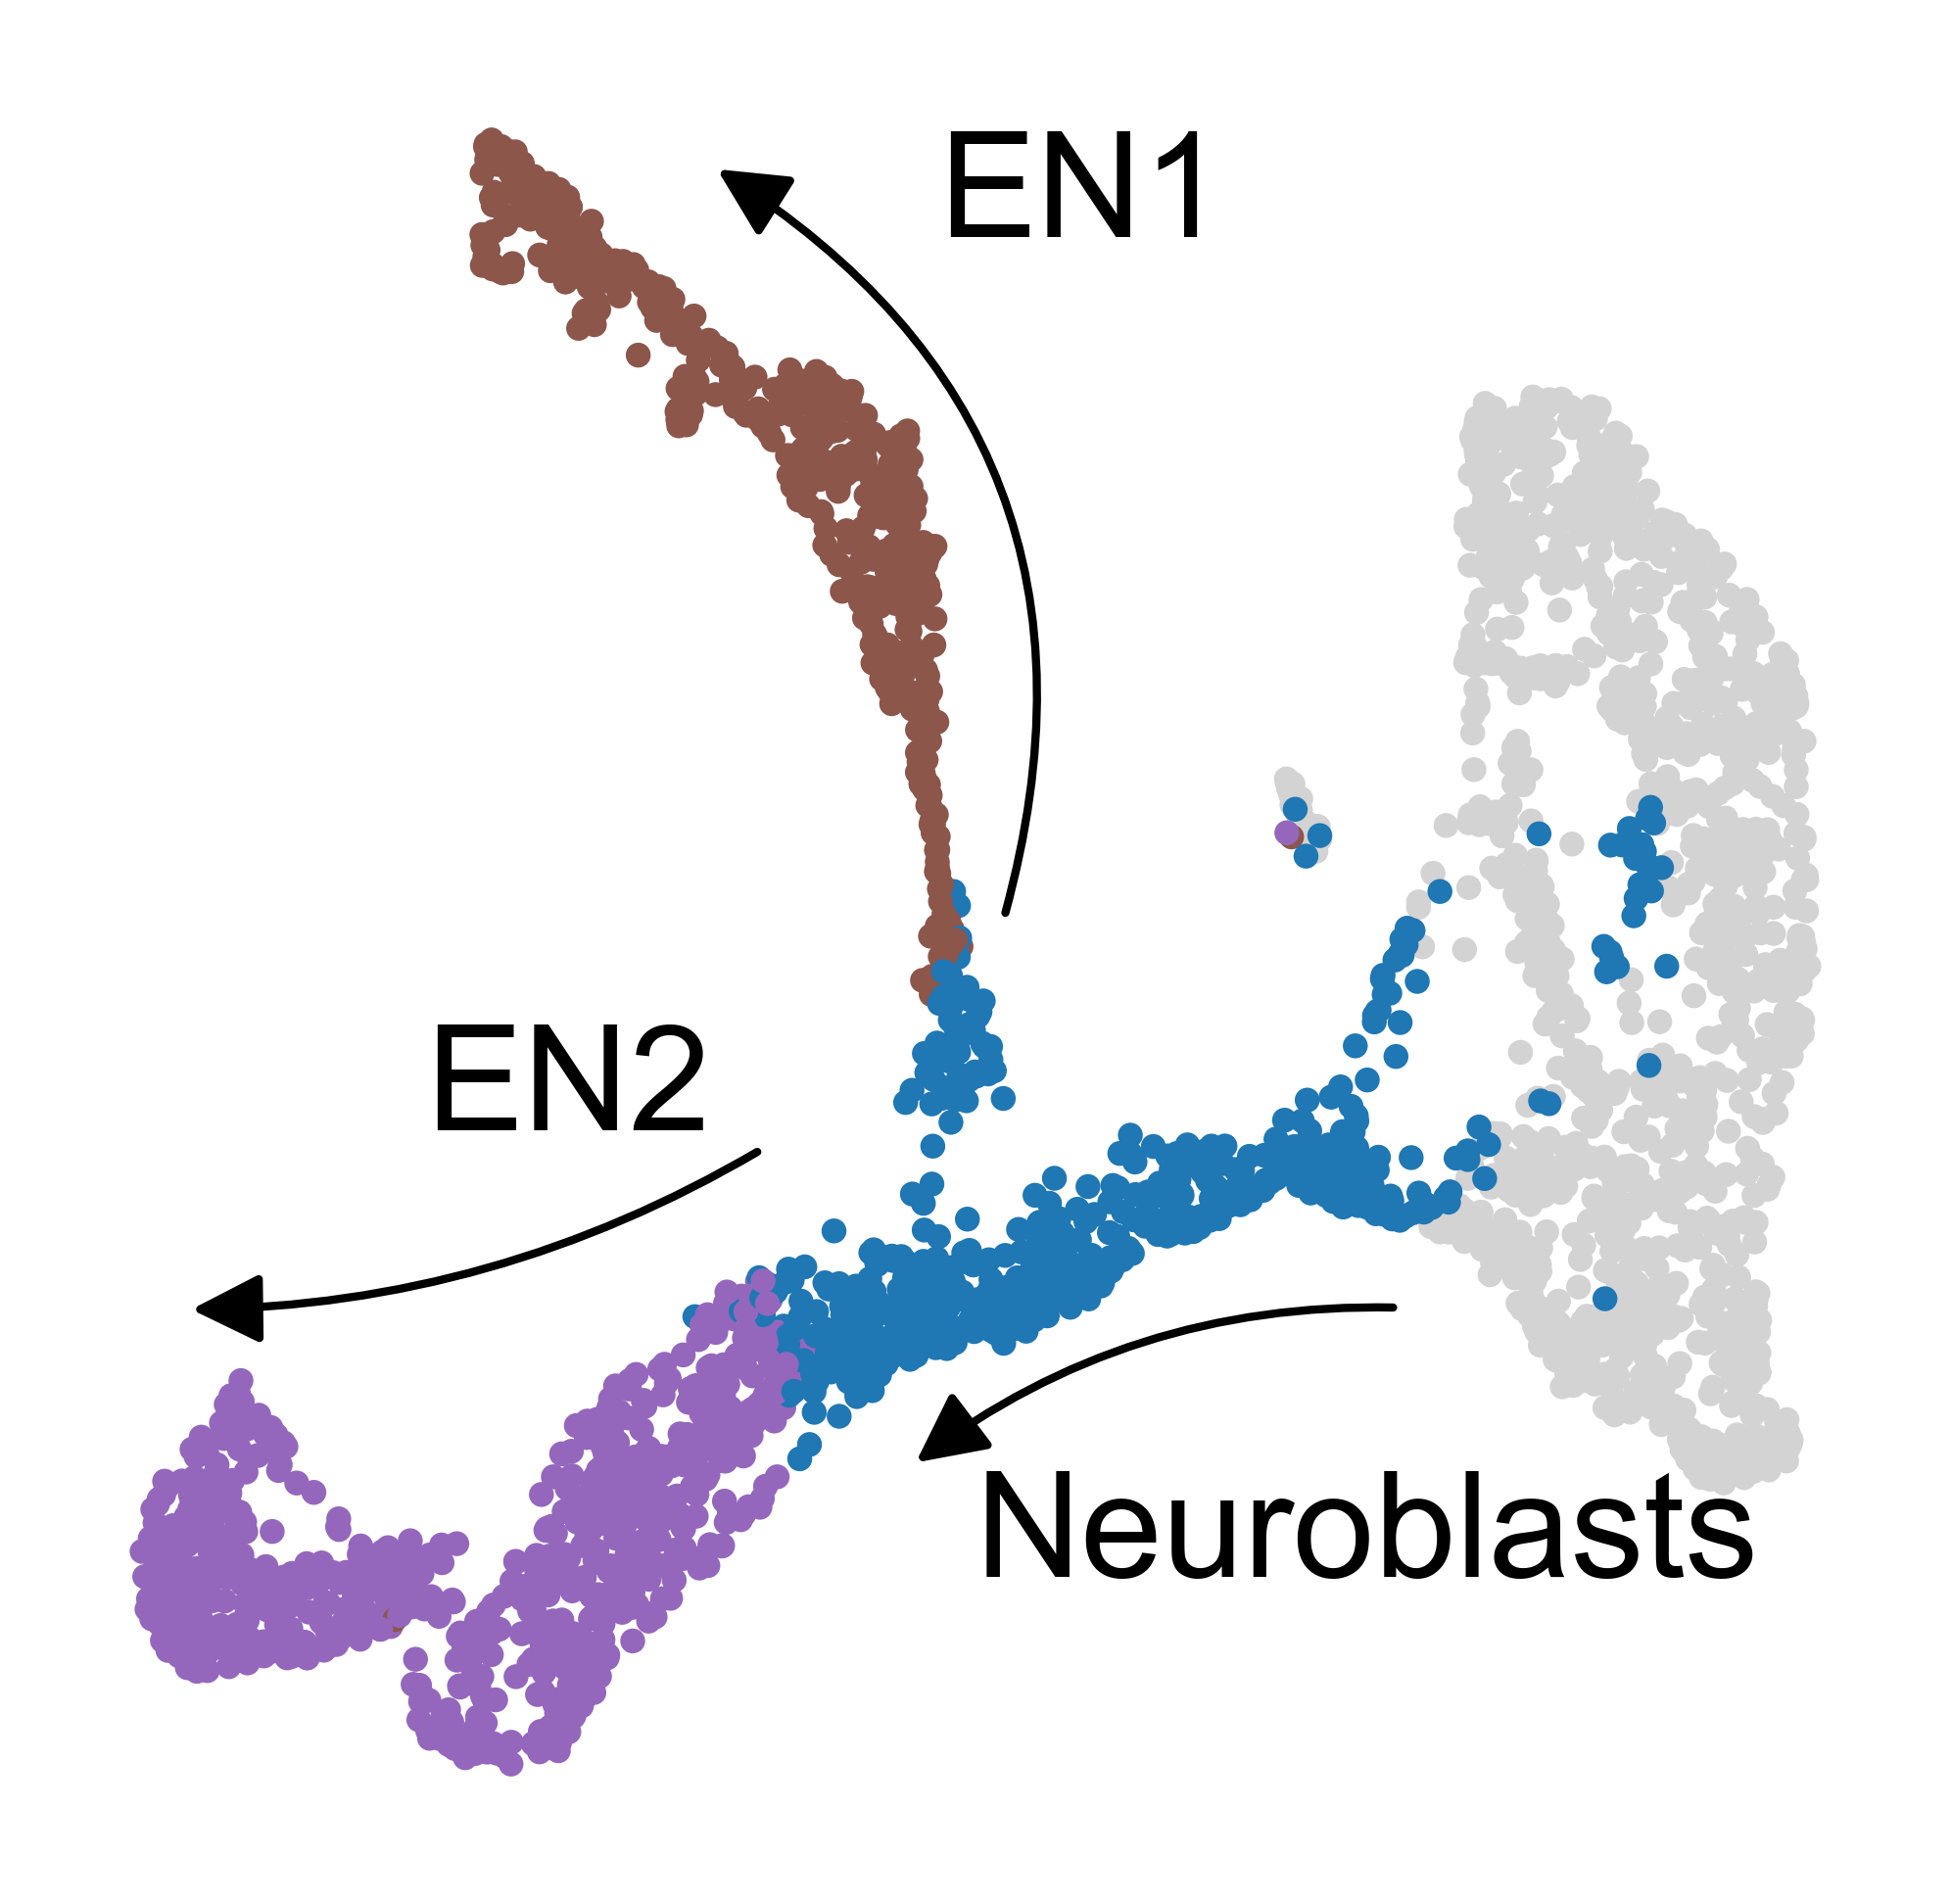

In [37]:
scv.set_figure_params(figsize=(4,4),fontsize=18,dpi=300)
scf.set_figure_pubready()
ax=sc.pl.umap(adata,color=["seg"],groups=["2","4","5"],
                frameon=False,legend_loc="none",title="",show=False)

ax.annotate("",(0.75,0.3),(0.45,0.2),xycoords="axes fraction",arrowprops=dict(arrowstyle="<|-", color="k",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=-.2",
                                ))

ax.annotate("Neuroblasts",(0.5,0.15),xycoords="axes fraction")


ax.annotate("",(0.51,0.5),(0.34,0.95),xycoords="axes fraction",arrowprops=dict(arrowstyle="<|-", color="k",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=-.4",
                                ))
ax.annotate("EN1",(0.48,0.9),xycoords="axes fraction")

ax.annotate("",(0.4,0.4),(0.05,0.3),xycoords="axes fraction",arrowprops=dict(arrowstyle="<|-", color="k",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle="arc3,rad=.15",
                                ))

ax.annotate("EN2",(0.2,0.4),xycoords="axes fraction")
plt.savefig("figures/ens_annot.pdf")

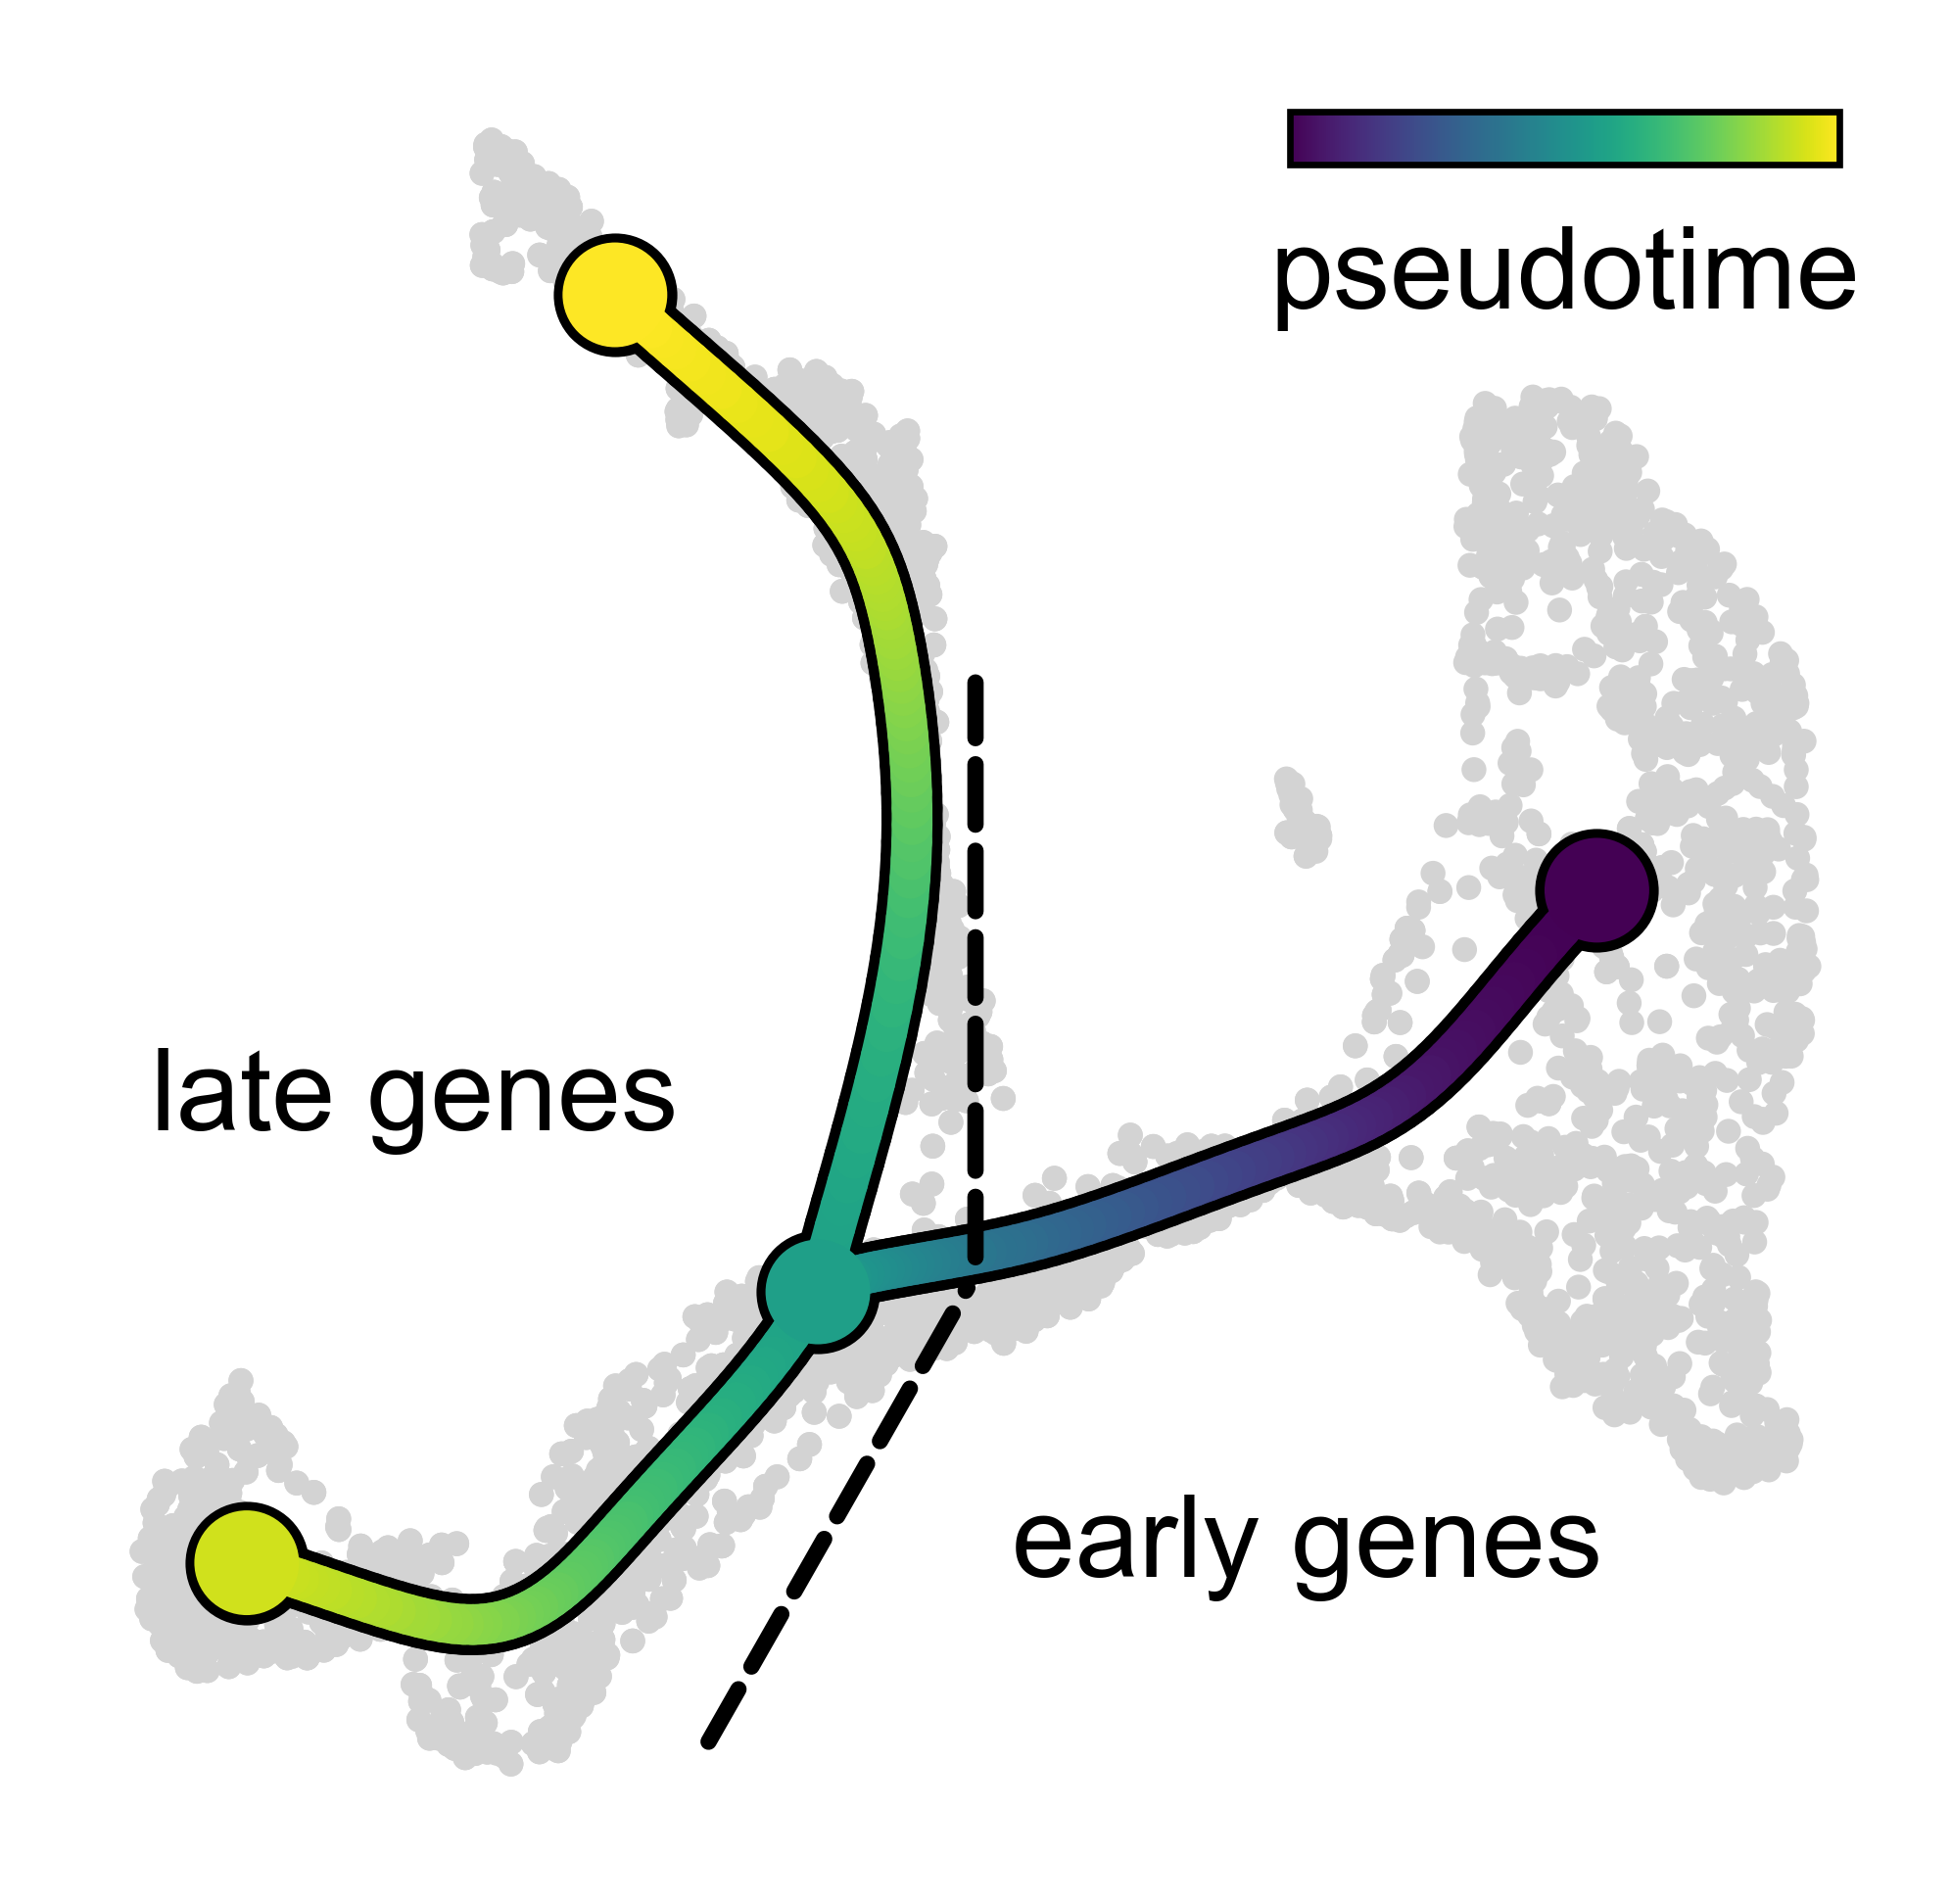

In [38]:
import matplotlib
from matplotlib import cm
sc.set_figure_params(dpi=300)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax=scf.pl.trajectory(adata,root_milestone="root",milestones=["EN1","EN2"],frameon=False,show=False)
cbaxes = inset_axes(ax, width="30%", height="3%",loc=1) 

cb1 = matplotlib.colorbar.ColorbarBase(cbaxes, cmap=cm.viridis,
                                orientation='horizontal'  ,                    
                                ticks=[],label="pseudotime",
                                )


ax.annotate("",xy=(0.5,0.66),xytext=(0.5,0.32),xycoords="axes fraction",
  arrowprops={"arrowstyle":"-","linestyle":"--","linewidth":2},zorder=10000)

ax.annotate("",xy=(0.5,.32),xytext=(0.35,0.05),xycoords="axes fraction",
  arrowprops={"arrowstyle":"-","linestyle":"--","linewidth":2},zorder=10000)

ax.annotate("late genes",xy=(0.05,0.4),xycoords="axes fraction",zorder=10000,size=14)
ax.annotate("early genes",xy=(0.52,0.15),xycoords="axes fraction",zorder=10000,size=14)

plt.savefig("figures/early_pseudotime.pdf")

In [39]:
fname="report_ENS"

In [47]:
%%bash -s $fname
cat<<EOF >$1.tex
\documentclass{article}
\usepackage[paperheight=142mm,paperwidth=210mm]{geometry}
\geometry{left=5mm,right=5mm,top=5mm,bottom=5mm,}
 
\usepackage[labelfont=bf]{caption}
\usepackage[rgb]{xcolor}
\usepackage{fontspec}
\usepackage[utf8]{inputenc}
\usepackage[T1]{fontenc}
\usepackage{graphbox,graphicx} 
\usepackage{adjustbox}

\begin{document}
\setmainfont{Arial}

\noindent
\normalsize 

\fontsize{10pt}{10pt}\selectfont


\raggedright \begin{minipage}[t]{.25\textwidth}
\raggedright \textbf{a} published ENS data
\includegraphics[width=\textwidth]{figures/ens_annot.pdf}
\end{minipage}\hfill
\begin{minipage}[t]{.25\textwidth}
\raggedright \textbf{c} selection of early genes
\includegraphics[width=\textwidth]{figures/early_pseudotime.pdf}
\end{minipage}\hfill
\begin{minipage}[t]{.24\textwidth}
\raggedright \textbf{b} co-activation of modules
\includegraphics[width=\textwidth]{figures/modulesupreg_early.pdf}
\end{minipage}\hfill
\begin{minipage}[t]{.26\textwidth}
\raggedright \textbf{c} example of early genes
\includegraphics[width=\textwidth]{figures/early_trends.pdf}

\end{minipage}\hfill

\raggedright \textbf{d} repulsion of early gene modules prior bifurcation
\includegraphics[width=\textwidth]{figures/slide_corsEN1_EN2.pdf}

\clearpage
EOF
echo "\end{document}" >> $1.tex

xelatex --shell-escape $1.tex
rm $1.tex $1.aux $1.log
convert -flatten -density 300 $1.pdf $1.jpg

identify $1.pdf

This is XeTeX, Version 3.14159265-2.6-0.999991 (TeX Live 2019/Debian) (preloaded format=xelatex)
 \write18 enabled.
entering extended mode
(./report_ENS.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/caption/caption.sty
(/usr/share/texlive/texmf-dist/tex/latex/caption/caption3.sty))
(/usr/share/texlive/texmf-dist/tex/latex/xcolor/xcolor.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/color.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/xetex.def))
(/usr/share/texlive/texm

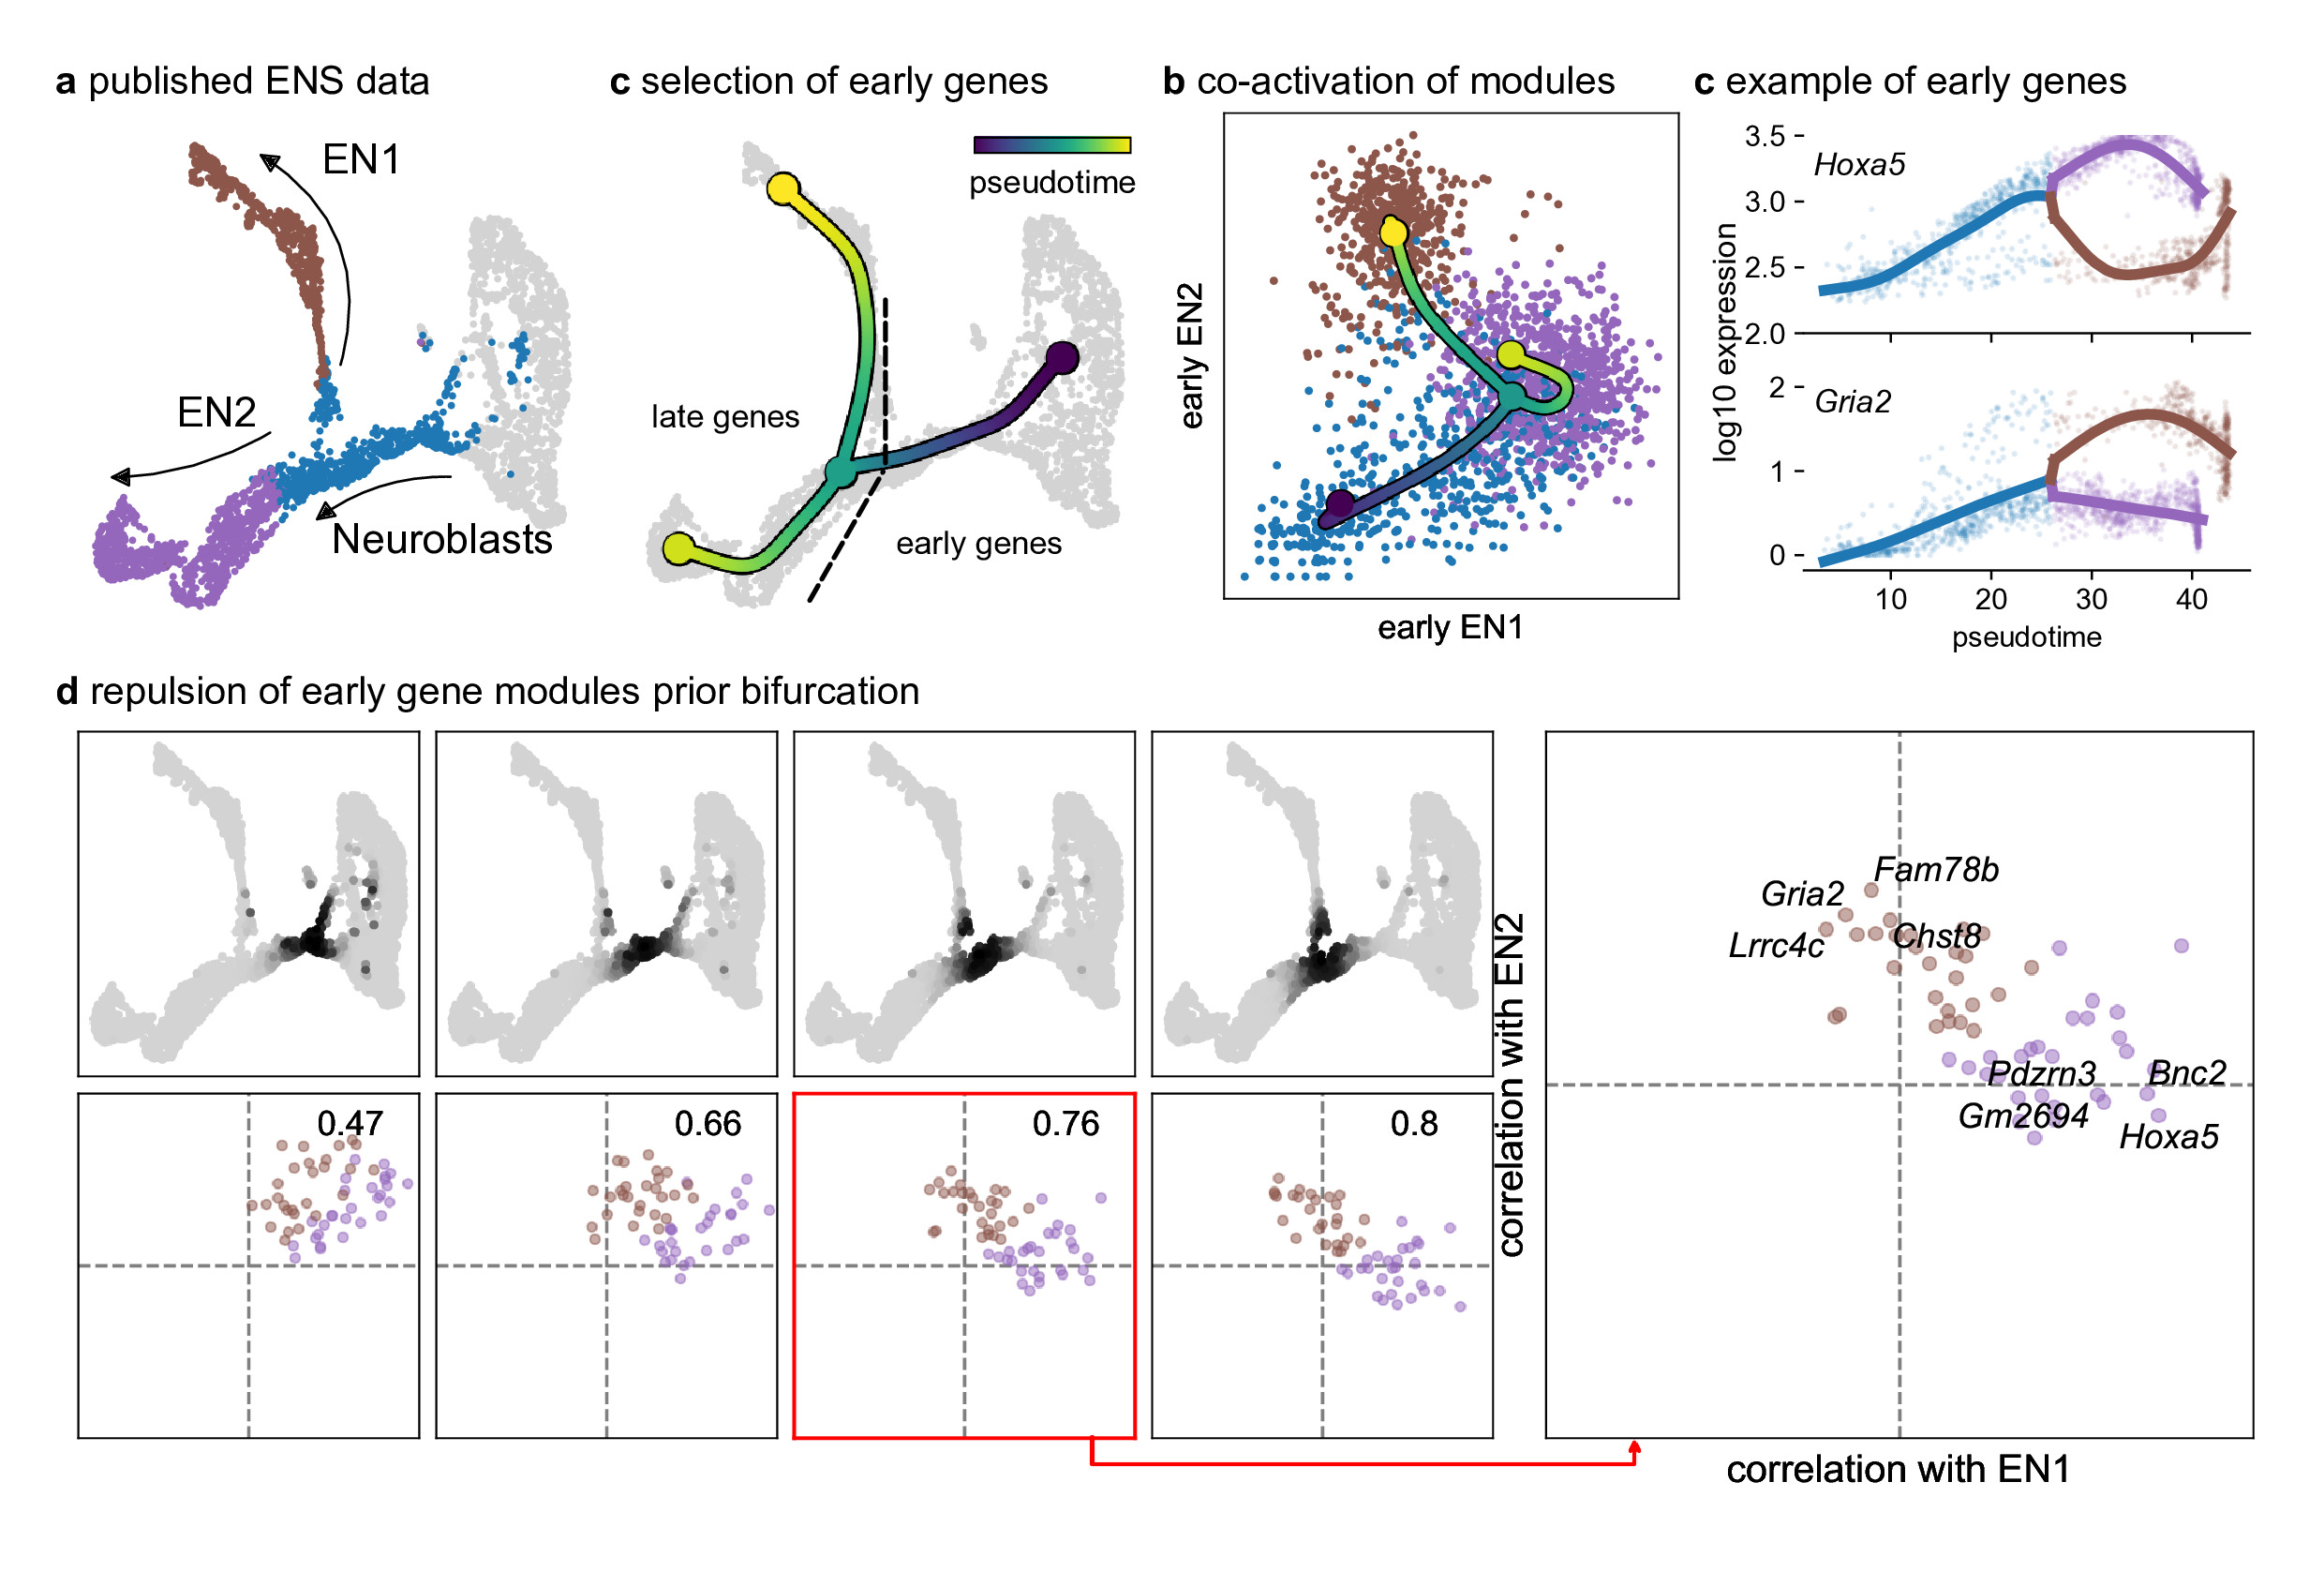

In [48]:
from IPython.display import Image
Image(filename=fname+'.jpg') 